# **🛰️ Sentinel-1 (VV/VH) SAR-BASED FLOOD DETECTION**


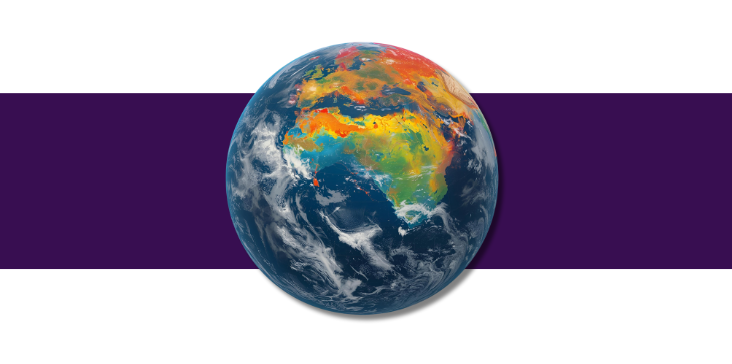


This project aims to implement a robust and automated solution for **binary flood classification** (Flood vs. Non-Flood) using Synthetic Aperture Radar (SAR) imagery from the **Sentinel-1** mission, leveraging the **SEN12FLOOD** dataset.

<br>

#### **Task (T):**
The task is to enable the machine learning model to detect and predict flooded areas from satellite imagery.
<br><br>
####**Why SAR?**  
- **VV** emphasizes reflections from smooth surfaces (water, infrastructure).  
- **VH** emphasizes cross-polarized scattering from vegetation and rough terrain.  
Together, they provide complementary flood cues even under clouds or night conditions.
<br>

#### **Our Approach:**

We implement a full machine-learning pipeline using a **CNN classifier, Random Forest, and SVM-RBF**, built on three core stages:

1.  **Preprocessing & Feature Engineering:** We convert raw VV/VH backscatter data to the $\text{dB}$ scale, apply the **Lee speckle filter** for noise reduction, and generate a set of **six advanced SAR features** (including polarization ratios and differences) for enhanced discrimination between water and land.
2.  **Data Preparation:** The image tiles are meticulously processed, split into Train/Validation/Test sets, and carefully **balanced** to ensure the model trains effectively on both flood and non-flood scenarios.
3.  **Model Training:** Train multiple model architectures to classify flooded vs. non-flooded tiles, supporting rapid and reliable flood-mapping decisions.

<br>

#### **Dataset Source:**
SEN12-FLOOD — Sentinel-1 Synthetic Aperture Radar (SAR) with flood annotations in GeoJSON.  
https://www.kaggle.com/datasets/virajkadam/sen12flood



## **Setting Up The data**


---



In [ ]:
!pip install -q rasterio geopandas shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 108.0 MB/s eta 0:00:00


In [ ]:
!pip uninstall torch -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 137.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.6 MB/s eta 0:00:00
     ━━

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

In [ ]:
import os, re, glob, json, random
from pathlib import Path
import numpy as np
import rasterio
from rasterio.features import rasterize
from rasterio.plot import plotting_extent
import geopandas as gpd
import matplotlib.pyplot as plt
import os, glob, json, random, re
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from pathlib import Path
import json, glob, os
import matplotlib.pyplot as plt
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import imageio.v3 as iio

**Paths**

In [ ]:
ROOT = "/content/drive/MyDrive/sen12flood"
S1_SRC_ROOT = os.path.join(ROOT, "sen12floods_s1_source", "sen12floods_s1_source")
S1_LBL_ROOT = os.path.join(ROOT, "sen12floods_s1_labels", "sen12floods_s1_labels")


OUT_DIR = Path("/content/sen12flood_npz_full_6feats").resolve()
for sp in ["train","val","test"]:
    (OUT_DIR/sp).mkdir(parents=True, exist_ok=True)

**Config**

In [ ]:
TILE_SIZE = 256
STRIDE    = 128
SEED = 42
USE_LEE = True
random.seed(SEED); np.random.seed(SEED)

## **Exploratory Data Analysis (EDA)**


---



Exploring the dataset to gain general understanding about the dataset.


| Property | Description / Value |
|-----------|--------------------|
| Total tiles | 3,331 |
| Image size | 518 × 521 pixels |
| Features (bands) | VV, VH |
| Classes | Flooded / Non-Flooded |
| Flooded tiles | 1,031 (30.95%) |
| Non-Flooded tiles | 2,300 (69.05%) |

### 1.Exploring Dataset Structure

Exploring the folder organization of the raw Sentinel-1 dataset to understand how the tiles and sequences are arranged.

In [ ]:
#Step 1: Exploring Folder Structure
from glob import glob
import os

label_folders = sorted(glob(os.path.join(S1_LBL_ROOT, "sen12floods_s1_labels_*")))
print(f"Total Sentinel-1 labeled folders: {len(label_folders)}")
print("Example folder:", label_folders[0])

Total Sentinel-1 labeled folders: 3331
Example folder: /content/drive/MyDrive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/sen12floods_s1_labels_0001_2018_12_23


### 2.Inspect Example Tile

Inspect one example tile to verify that each labeled folder contains the expected files and metadata structure before further analysis.


In [ ]:
#Step 2: Inspect Example Tile
import os, json

example_folder = label_folders[0]
print("Example Folder:", example_folder)

files = os.listdir(example_folder)
print("Files inside:", files)

# Optional: show sample label info
geojson_path = os.path.join(example_folder, "labels.geojson")
if os.path.exists(geojson_path):
    with open(geojson_path, "r") as f:
        sample_label = json.load(f)
    print("\nSample Label Properties:")
    print(sample_label["properties"])


Example Folder: /content/drive/MyDrive/sen12flood/sen12floods_s1_labels/sen12floods_s1_labels/sen12floods_s1_labels_0001_2018_12_23
Files inside: ['labels.geojson', 'stac.json', 'flood_mask_from_geojson.tif']

Sample Label Properties:
{'FLOODING': False, 'date': '2018-12-23', 'orbit': 'ASCENDING', 'tile': '0001'}


### 3.Flood vs Non-Flood Analysis

#### 3.1 Counting labeled folders

Estimate how many labeled folders represent flooded vs non-flooded scenes to understand the class balance before processing.

In [ ]:
#Step 3.1: Counting Labeled Folders (Flood vs Non-Flood)
import json

flood_count = 0
non_flood_count = 0

for folder in label_folders:
    geojson_path = os.path.join(folder, "labels.geojson")
    if not os.path.exists(geojson_path):
        continue

    with open(geojson_path, "r") as f:
        data = json.load(f)
        flood = int(data["properties"].get("FLOODING", 0))
        if flood == 1:
            flood_count += 1
        else:
            non_flood_count += 1

print("=== Label Summary ===")
print(f"Flooded scenes: {flood_count}")
print(f"Non-flooded scenes: {non_flood_count}")

total = flood_count + non_flood_count
print(f"Total labeled folders: {total}")
print(f"Flood ratio: {(flood_count / total) * 100:.2f}%")


=== Label Summary ===
Flooded scenes: 1031
Non-flooded scenes: 2300
Total labeled folders: 3331
Flood ratio: 30.95%


#### 3.2 Visualizing Flood Distribution

Show the distribution between flooded and non-flooded samples using a simple bar chart to visualize class balance.

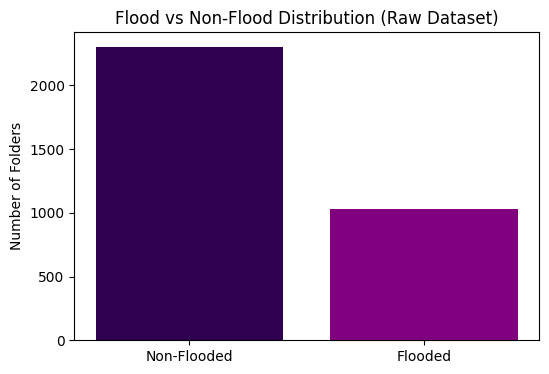

In [ ]:
# Step 3.2: Visualizing Flood Distribution
import matplotlib.pyplot as plt

labels = ["Non-Flooded", "Flooded"]
counts = [non_flood_count, flood_count]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=["#2E004F", "purple"])
plt.title("Flood vs Non-Flood Distribution (Raw Dataset)")
plt.ylabel("Number of Folders")
plt.show()

>The bar chart shows the class distribution in the raw dataset. It illustrates a clear imbalance — the number of Non-Flooded folders (around 2200) is roughly twice that of Flooded folders (about 1000). This imbalance indicates that flood events are underrepresented, which could bias model training unless balancing techniques are applied.

### 4.Display Sample Images from the Dataset

Visualize a few random samples from the raw Sentinel-1 dataset to understand the data structure and verify that the flood and non-flood images are loaded correctly.

Found Flood=1031, Non-Flood=2300


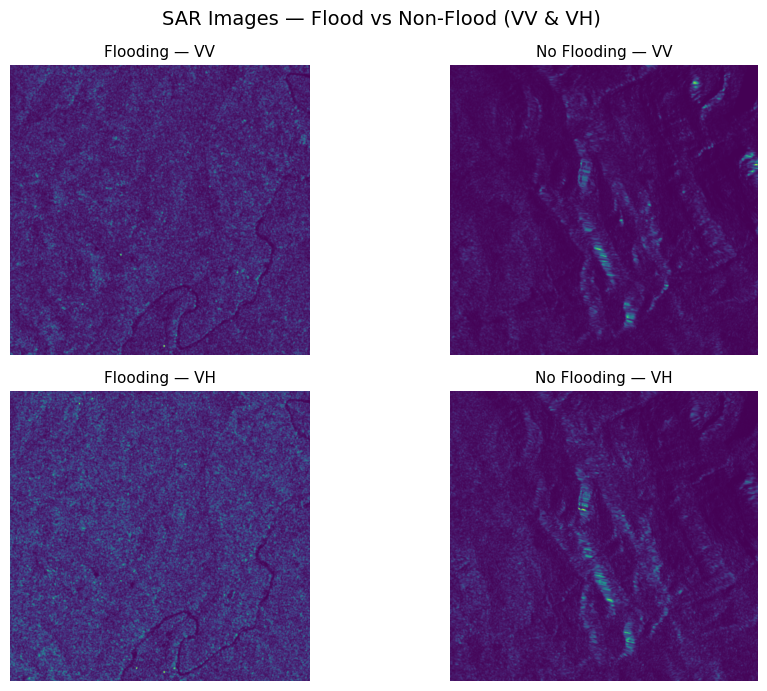

In [ ]:

# Build label and source maps

keys = [k for k in os.listdir(S1_LBL_ROOT) if k.startswith("sen12floods_s1_labels_")]
lbl_map = {k: os.path.join(S1_LBL_ROOT, k) for k in keys}
src_map = {k: os.path.join(S1_SRC_ROOT, k.replace("labels", "source")) for k in keys}

# Extract Flood / Non-Flood keys

def parse_label(folder):
    """Read 'labels.geojson' and extract FLOODING value (0 or 1)."""
    gj = os.path.join(folder, "labels.geojson")
    if not os.path.exists(gj):
        return None
    with open(gj, "r") as f:
        props = json.load(f).get("properties", {})
    return int(props.get("FLOODING", 0))

flood_keys, non_keys = [], []
for k in keys:
    lbl_dir = lbl_map[k]
    y = parse_label(lbl_dir)
    if y is None:
        continue
    (flood_keys if y == 1 else non_keys).append(k)

print(f"Found Flood={len(flood_keys)}, Non-Flood={len(non_keys)}")


# Visualization — Flood vs Non-Flood SAR Samples

def norm(x):
    """Normalize pixel values to range [0, 1]."""
    x = x.astype(float)
    return (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-8)

# Randomly select one Flood and one Non-Flood sample
flood_sample = random.choice(flood_keys)
non_sample = random.choice(non_keys)

# File paths for VV and VH bands
vv_flood = os.path.join(src_map[flood_sample], "VV.tif")
vh_flood = os.path.join(src_map[flood_sample], "VH.tif")
vv_non = os.path.join(src_map[non_sample], "VV.tif")
vh_non = os.path.join(src_map[non_sample], "VH.tif")

# Read and normalize images
vv_flood_img = norm(iio.imread(vv_flood))
vh_flood_img = norm(iio.imread(vh_flood))
vv_non_img = norm(iio.imread(vv_non))
vh_non_img = norm(iio.imread(vh_non))

# Smaller figure size for EDA
fig, ax = plt.subplots(2, 2, figsize=(10, 7))
plt.suptitle("SAR Images — Flood vs Non-Flood (VV & VH)", fontsize=14)

# --- VV Band ---
ax[0, 0].imshow(vv_flood_img, cmap='viridis')
ax[0, 0].set_title("Flooding — VV", fontsize=11)
ax[0, 0].axis('off')

ax[0, 1].imshow(vv_non_img, cmap='viridis')
ax[0, 1].set_title("No Flooding — VV", fontsize=11)
ax[0, 1].axis('off')

# --- VH Band ---
ax[1, 0].imshow(vh_flood_img, cmap='viridis')
ax[1, 0].set_title("Flooding — VH", fontsize=11)
ax[1, 0].axis('off')

ax[1, 1].imshow(vh_non_img, cmap='viridis')
ax[1, 1].set_title("No Flooding — VH", fontsize=11)
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()


### 5️.Temporal Flood Analysis (by Date)

Analyze how flood events are distributed over time to identify seasonal or temporal patterns in the dataset.

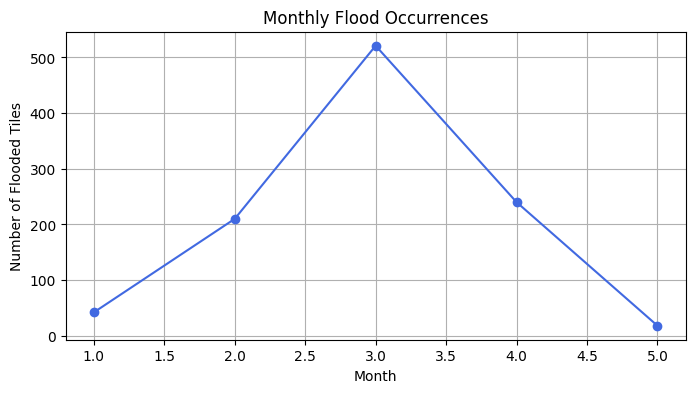

In [ ]:
#Step 5: Temporal Flood Analysis
import pandas as pd
import matplotlib.pyplot as plt
import json

# Collect flood occurrences by date
date_counts = []

for folder in label_folders:
    geojson_path = os.path.join(folder, "labels.geojson")
    if not os.path.exists(geojson_path):
        continue

    with open(geojson_path, "r") as f:
        data = json.load(f)
        flood = int(data["properties"].get("FLOODING", 0))
        date = data["properties"].get("date", None)
        if flood == 1 and date:
            date_counts.append(date)

# Convert to DataFrame
df_dates = pd.DataFrame(date_counts, columns=["date"])
df_dates["date"] = pd.to_datetime(df_dates["date"])
df_dates["month"] = df_dates["date"].dt.month

# Group by month to see patterns
monthly_floods = df_dates["month"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8,4))
plt.plot(monthly_floods.index, monthly_floods.values, marker='o', color='royalblue')
plt.title("Monthly Flood Occurrences")
plt.xlabel("Month")
plt.ylabel("Number of Flooded Tiles")
plt.grid(True)
plt.show()


>The line chart illustrates the number of flooded tiles per month. Flood occurrences gradually increase from January (month 1) to a clear peak around March (month 3), where the highest number of flood events (~520 tiles) is observed. After March, flood frequency declines sharply through April and reaches its lowest point by May. This seasonal pattern suggests that floods are most prevalent during late winter to early spring.

### 6.Flooded vs Total Frames per Tile

Compare, for each tile_id, how many frames exist versus how many are labeled as flooded to reveal sequence-level class imbalance before preprocessing.

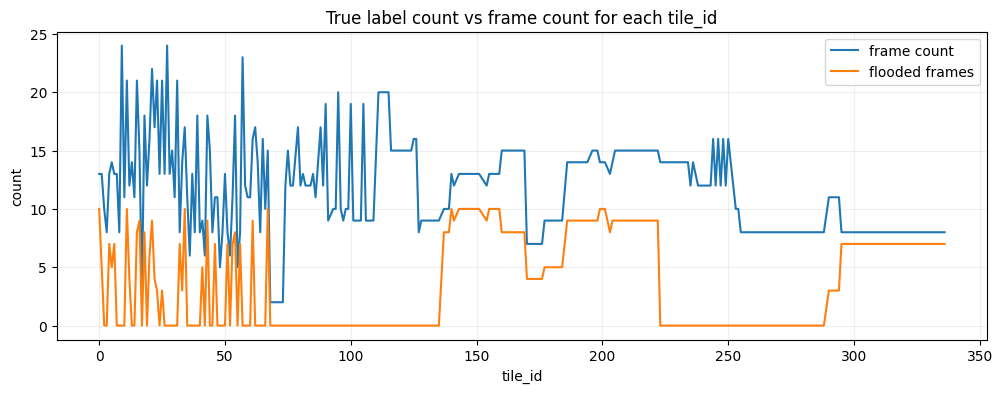

In [ ]:
# Step 5: Flooded vs Total Frames per Tile (Raw)
import os, json
import pandas as pd
import matplotlib.pyplot as plt

# Build a lightweight table: one row per labeled frame
records = []
for folder in label_folders:
    gj = os.path.join(folder, "labels.geojson")
    if not os.path.exists(gj):
        continue
    with open(gj, "r") as f:
        props = json.load(f)["properties"]
    records.append({
        "tile_id": int(props.get("tile")),
        "flood_label": int(props.get("FLOODING", 0))  # 1=flood, 0=non-flood
    })

df_seq = pd.DataFrame(records)

if df_seq.empty:
    print("No labeled frames found. Please verify S1_LBL_ROOT / mount paths.")
else:
    # counts per sequence
    frame_per_tile = df_seq["tile_id"].value_counts().sort_index()
    flood_per_tile = df_seq.groupby("tile_id")["flood_label"].sum()

    # align indices just in case
    idx = frame_per_tile.index.union(flood_per_tile.index)
    frame_per_tile = frame_per_tile.reindex(idx, fill_value=0)
    flood_per_tile = flood_per_tile.reindex(idx, fill_value=0)

    # plot
    plt.figure(figsize=(12,4))
    plt.plot(idx, frame_per_tile.values, label="frame count")
    plt.plot(idx, flood_per_tile.values, label="flooded frames")
    plt.title("True label count vs frame count for each tile_id")
    plt.xlabel("tile_id")
    plt.ylabel("count")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


>The plot compares the total number of image frames (`frame count`, blue) and the number of flooded frames (`flooded frames`, orange) for each tile ID. While most tiles contain multiple image frames, only a subset of them show flooding. The orange line being consistently lower than the blue line indicates that flooding is relatively rare within most tiles. A few tiles show higher flooded-frame counts, suggesting that flood events are geographically localized rather than evenly distributed across all regions.


## **Data Pre-Processing**


---



### 1.Regex to match label directories

Extracts tile_id and date from label folder names; maps labels to corresponding source folders (post-event), and optionally finds pre-event source.

In [ ]:
# sen12floods_s1_labels_<tileid>_<yyyy>_<mm>_<dd>
LABEL_DIR_RE = re.compile(r"sen12floods_s1_labels_(\d+)_([0-9]{4})_([0-9]{2})_([0-9]{2})$")

def find_matching_src(lbl_dir, src_root):
    m = LABEL_DIR_RE.search(os.path.basename(lbl_dir))
    if not m: return None, None
    tile_id, y, mth, d = m.group(1), m.group(2), m.group(3), m.group(4)
    src_dir = os.path.join(src_root, f"sen12floods_s1_source_{tile_id}_{y}_{mth}_{d}")
    return (src_dir if os.path.isdir(src_dir) else None), (tile_id, f"{y}_{mth}_{d}")

def try_find_pre_dir(src_root, key_tuple):
    tile_id, ymd = key_tuple
    y, mth, d = ymd.split("_")
    cand = os.path.join(src_root, f"sen12floods_s1_source_pre_{tile_id}_{y}_{mth}_{d}")
    return cand if os.path.isdir(cand) else None

### 2.SAR Tools (to dB, Lee filter, 6 features, VV/VH reader)

This step is done to improve the quality of radar (SAR) images and to extract strong numerical features that help the model distinguish between flooded and non-flooded areas.

What it does:

- **to_db**: converts linear power to dB and sanitizes infinities.

- **lee_filter**: reduces speckle using Lee filter (approx).

- **mk_6_features**: builds 6-channel SAR feature stack (VV_dB, VH_dB, sum/diff in dB, linear ratio, linear product).

- **read_vv_vh_from_dir**: loads VV/VH rasters and metadata.

In [ ]:
def to_db(x, eps=1e-6):
    # Convert SAR power to dB, clip small values to avoid log(0)
    x = np.clip(x, eps, None)
    out = 10.0 * np.log10(x)
    out[~np.isfinite(out)] = 0.0
    return out.astype(np.float32)

def lee_filter(img, size=5):
    # Apply Lee speckle filter to reduce noise in SAR
    img = img.astype(np.float32)
    mean = uniform_filter(img, size=size)
    mean_sq = uniform_filter(img**2, size=size)
    var = mean_sq - mean**2
    overall_var = np.nanmean(var)
    w = var / (var + overall_var + 1e-6)
    return (mean + w * (img - mean)).astype(np.float32)

def mk_6_features(vv_db, vh_db):
    # Compute 6 SAR features:
    # 1) VV dB
    # 2) VH dB
    # 3) VV+VH dB
    # 4) VV-VH dB
    # 5) VV/VH linear ratio
    # 6) VV*VH linear product
    vv_lin = 10.0 ** (vv_db / 10.0)
    vh_lin = 10.0 ** (vh_db / 10.0)
    feats = np.stack([
        vv_db,                    # 1
        vh_db,                    # 2
        vv_db + vh_db,            # 3
        vv_db - vh_db,            # 4
        vv_lin / (vh_lin + 1e-6), # 5
        vv_lin * vh_lin           # 6
    ], axis=0).astype(np.float32)
    return np.nan_to_num(feats, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
#Read VV/VH from a source folder (post or pre)
def read_vv_vh_from_dir(src_dir):
    vv_path = sorted(glob.glob(os.path.join(src_dir, "*VV*.tif")))
    vh_path = sorted(glob.glob(os.path.join(src_dir, "*VH*.tif")))
    if not vv_path or not vh_path:
        raise FileNotFoundError(f"No VV/VH GeoTIFFs in {src_dir}")
    vv_path, vh_path = vv_path[0], vh_path[0]
    with rasterio.open(vv_path) as src_vv:
        vv = src_vv.read(1); crs = src_vv.crs; transform = src_vv.transform
        H, W = src_vv.height, src_vv.width
    with rasterio.open(vh_path) as src_vh:
        vh = src_vh.read(1)
    return vv.astype(np.float32), vh.astype(np.float32), crs, transform, (H, W), vv_path

### 3.Consolidate S1 image (VV/VH)
Reads VV/VH, converts to dB, optionally applies Lee, and returns 6-feature tensor and georeferencing.

In [ ]:
#CONSOLIDATED FUNCTION: Processes S1 image (VV/VH)
def process_s1_image(src_dir, use_lee):
    vv, vh, crs, transform, shape, vv_path = read_vv_vh_from_dir(src_dir)
    vv_db = to_db(vv)
    vh_db = to_db(vh)
    if use_lee:
        vv_db = lee_filter(vv_db, size=5)
        vh_db = lee_filter(vh_db, size=5)

    # Compute 6 features
    feats = mk_6_features(vv_db, vh_db)
    return feats, crs, transform, shape, vv_path

### 4.Rasterize mask (positive only)
To convert flood polygons from a GeoJSON file into a raster (pixel-based) mask that marks only the flooded pixels (value = 1) on the same grid as the radar image, which will later be used to build and train the model.

In [ ]:
#Rasterize mask (positive flood pixels only)
def rasterize_mask_positive_only(geojson_path, out_crs, out_shape, out_transform, all_touched=True):
    gdf = gpd.read_file(geojson_path)
    if gdf.crs is None: gdf.set_crs("EPSG:4326", inplace=True)
    # Detect flood column
    col = None
    for k in ("FLOODING","flooding","FLOODED","flooded","is_flood","flood"):
        if k in gdf.columns:
            col = k; break
    if col is None:
        return np.zeros(out_shape, dtype=np.uint8)
    # Keep only positive flood pixels
    try:
        s_num = pd.to_numeric(gdf[col], errors="coerce").fillna(0)
        gdf = gdf[s_num > 0]
    except Exception:
        s_str = gdf[col].astype(str).str.lower()
        gdf = gdf[s_str.isin(["true","1","yes","y"])]
    if gdf.empty:
        return np.zeros(out_shape, dtype=np.uint8)
    gdf = gdf.to_crs(out_crs)
    gdf["geometry"] = gdf["geometry"].buffer(0)
    gdf = gdf[~gdf.geometry.is_empty & gdf.geometry.is_valid]
    if gdf.empty:
        return np.zeros(out_shape, dtype=np.uint8)
    shapes = [(geom, 1) for geom in gdf.geometry if geom is not None]
    return rasterize(shapes=shapes, out_shape=out_shape, transform=out_transform,
                     fill=0, default_value=1, dtype=np.uint8, all_touched=all_touched)

### 5.Split image into 256x256 tiles
This function divides the large satellite (SAR) image into smaller 256×256 pixel tiles by determining the starting pixel coordinates of each tile, so they can fit into memory and match the neural network’s input size.

In [ ]:
#Split image into 256x256 tiles
def tile_coords(H, W, tile_size=256, stride=256):
    coords=[]
    for y in range(0, H - tile_size + 1, stride):
        for x in range(0, W - tile_size + 1, stride):
            coords.append((y,x))
    return coords

### 6.Dataset Splitting (train/val/test)
Partitions unique (tile_id, date) keys into 70/15/15 splits to avoid leakage across splits.

In [ ]:
#Split data into train/val/test
lbl_tiles = sorted([p for p in glob.glob(os.path.join(S1_LBL_ROOT, "sen12floods_s1_labels_*")) if os.path.isdir(p)])
pairs=[]
for lbl_dir in lbl_tiles:
    src_dir, key = find_matching_src(lbl_dir, S1_SRC_ROOT)
    if src_dir and os.path.exists(os.path.join(lbl_dir,"labels.geojson")):
        pairs.append({"lbl_dir": lbl_dir, "src_dir_post": src_dir, "key": key})

uniq = sorted({p["key"] for p in pairs})
random.shuffle(uniq)
n=len(uniq); ntr=int(0.70*n); nval=int(0.15*n)
train_keys=set(uniq[:ntr]); val_keys=set(uniq[ntr:ntr+nval]); test_keys=set(uniq[ntr+nval:])
def split_of(key): return "train" if key in train_keys else ("val" if key in val_keys else "test")

In [ ]:
#Build full dataset and save tiles
manifest = {"meta": {}, "items": []}
pos_pix = 0
neg_pix = 0

for p in tqdm(pairs, desc="FULL build (6 features)"):
    split = split_of(p["key"])

    #Read and process POST images (VV/VH, dB, Lee, 6 features)
    try:
        feats_after, crs, transform, (H, W), vv_post_path = process_s1_image(p["src_dir_post"], USE_LEE)
    except FileNotFoundError:
        continue # Skip if POST images are not found

    #Read PRE images and compute delta features
    pre_dir = try_find_pre_dir(S1_SRC_ROOT, p["key"])
    feats_delta = None
    if pre_dir:
        try:
            feats_before, _, _, _, _ = process_s1_image(pre_dir, USE_LEE)
            #Ensure shapes match before subtraction
            if feats_after.shape == feats_before.shape:
                feats_delta = (feats_after - feats_before).astype(np.float32)
        except Exception:
            feats_delta = None  #If reading/processing fails, skip delta

In [ ]:
    # Rasterize mask (positive flood pixels only)
    mask = rasterize_mask_positive_only(
        os.path.join(p["lbl_dir"], "labels.geojson"),
        crs, (H, W), transform, all_touched=True
    ).astype(np.uint8)

### 7.Build tiles + save NPZ + manifest
Split large processed SAR images and their flood masks into smaller 256×256 tiles and save them as NPZ files, creating a structured dataset (with metadata) that can be directly used to train and evaluate the flood detection model.
What it does:

- Processes POST features, optionally computes DELTA (POST–PRE),

- Tiles images and masks,

- Saves .npz per tile (**x_after**, optional **x_delta**, **y**),

- Appends per-tile metadata (id, path, split, **pos_ratio**) to **manifest**.

In [ ]:
    # Split image into tiles and save as NPZ
    for (y, x0) in tile_coords(H, W, TILE_SIZE, STRIDE):
        xa = feats_after[:, y:y+TILE_SIZE, x0:x0+TILE_SIZE]  # POST features
        m = mask[y:y+TILE_SIZE, x0:x0+TILE_SIZE]              # mask

        item = {"split": split}

        if feats_delta is not None:
            xd = feats_delta[:, y:y+TILE_SIZE, x0:x0+TILE_SIZE]  # delta features
            uid = f"{os.path.basename(p['lbl_dir'])}_{y:04d}_{x0:04d}_AD"
            out_path = os.path.join(OUT_DIR, split, f"{uid}.npz")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            np.savez_compressed(
                out_path,
                x_after=xa.astype(np.float32),
                x_delta=xd.astype(np.float32),
                y=m.astype(np.uint8)
            )
            item["has_delta"] = True
        else:
            uid = f"{os.path.basename(p['lbl_dir'])}_{y:04d}_{x0:04d}_A"
            out_path = os.path.join(OUT_DIR, split, f"{uid}.npz")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            np.savez_compressed(
                out_path,
                x_after=xa.astype(np.float32),
                y=m.astype(np.uint8)
            )
            item["has_delta"] = False

        # Update manifest
        item["id"] = uid
        item["path"] = out_path
        item["pos_ratio"] = float(m.mean())
        manifest["items"].append(item)

        # Count pixels for statistics
        pos_pix += int((m == 1).sum())
        neg_pix += int((m == 0).sum())

In [ ]:
#Update manifest metadata
manifest["meta"]["pixel_balance"] = {"pos": int(pos_pix), "neg": int(neg_pix)}
manifest["meta"]["n_channels_after"] = 6
manifest["meta"]["n_channels_delta"] = 6
manifest["meta"]["features_after"] = ["VV_dB","VH_dB","VV_plus_VH_dB","VV_minus_VH_dB","VV_over_VH_linear","VVVH_linear"]
manifest["meta"]["features_delta"] = manifest["meta"]["features_after"]
manifest["meta"]["note"] = "Lee(5x5) approx in Python; prefer SNAP Lee Sigma for best quality."

In [ ]:
#Save manifest JSON
os.makedirs(OUT_DIR, exist_ok=True)
with open(os.path.join(OUT_DIR, "manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

## **Statistics & Information After Processing**


---



Loads manifest.json, normalizes paths to current OUT_DIR, and builds paths['train'|'val'|'test'].

In [ ]:
BASE_DIR = "/content/drive/MyDrive/sen12flood_npz_full_6feats"

mani_path = Path(BASE_DIR)/"manifest.json"

if mani_path.exists():
    mani = json.loads(mani_path.read_text())
else:
    # Fallback to load manifest from the temporary directory if drive path fails
    mani_path_temp = Path("/content/sen12flood_npz_full_6feats")/"manifest.json"
    if mani_path_temp.exists():
        mani = json.loads(mani_path_temp.read_text())
    else:
        print("Manifest file not found.")
        mani = {"items": []}
def fix_path(p: str) -> str:
    """OUT_DIR"""
    fname = os.path.basename(p)
    split = os.path.basename(os.path.dirname(p))
    return str(OUT_DIR / split / fname)

paths = {"train": [], "val": [], "test": []}
for it in mani["items"]:
    p_fixed = fix_path(it["path"])
    paths[it["split"]].append(p_fixed)

for split in ["train","val","test"]:
    print(split, "count:", len(paths[split]))
    print("sample:", paths[split][0])

### 1.Manifest Data Split

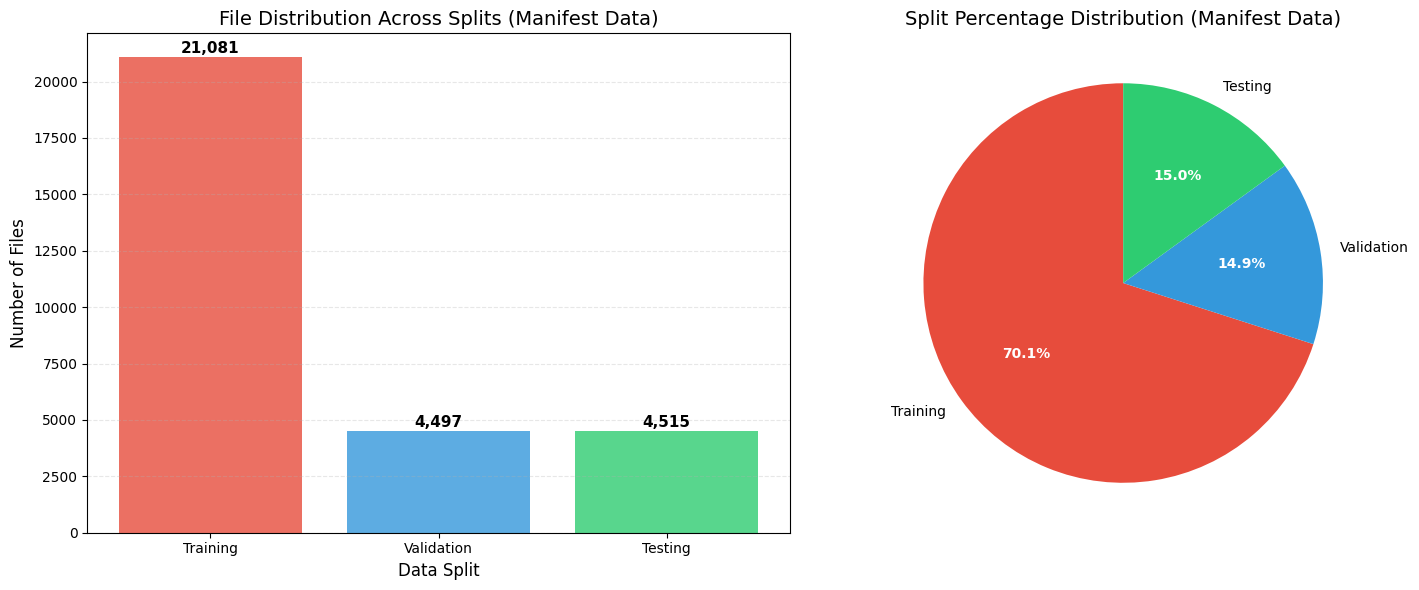

Manifest Data Split Summary:
train: 21081 files
  Sample: sen12floods_s1_labels_0001_2019_01_16_0000_0000_A.npz
val: 4497 files
  Sample: sen12floods_s1_labels_0005_2018_12_16_0000_0000_A.npz
test: 4515 files
  Sample: sen12floods_s1_labels_0001_2018_12_23_0000_0000_A.npz

 Visualization Statistics:
Training: 21,081 files (70.1%)
Validation: 4,497 files (14.9%)
Testing: 4,515 files (15.0%)

Total: 30,093 files
Train/Val/Test ratio: 4.7:1.0:1


In [ ]:
BASE_DIR = "/content/drive/MyDrive/sen12flood_npz_full_6feats"

mani_path = Path(BASE_DIR)/"manifest.json"

if mani_path.exists():
    mani = json.loads(mani_path.read_text())
else:
    # Fallback to load manifest from the temporary directory if drive path fails
    mani_path_temp = Path("/content/sen12flood_npz_full_6feats")/"manifest.json"
    if mani_path_temp.exists():
        mani = json.loads(mani_path_temp.read_text())
    else:
        print("Manifest file not found.")
        mani = {"items": []}

def fix_path(p: str) -> str:
    """OUT_DIR"""
    fname = os.path.basename(p)
    split = os.path.basename(os.path.dirname(p))
    return str(OUT_DIR / split / fname)

paths = {"train": [], "val": [], "test": []}
for it in mani["items"]:
    p_fixed = fix_path(it["path"])
    paths[it["split"]].append(p_fixed)

# Visualization for manifest-based data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Basic split data from manifest
split_names = ['Training', 'Validation', 'Testing']
file_counts = [len(paths['train']), len(paths['val']), len(paths['test'])]

# Plot 1: File counts only
bars1 = ax1.bar(split_names, file_counts, color=['#E74C3C', '#3498DB', '#2ECC71'], alpha=0.8)
ax1.set_xlabel('Data Split', fontsize=12)
ax1.set_ylabel('Number of Files', fontsize=12)
ax1.set_title('File Distribution Across Splits (Manifest Data)', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add numbers on bars
for bar, count in zip(bars1, file_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Percentages
percentages = [count/sum(file_counts)*100 for count in file_counts]
colors = ['#E74C3C', '#3498DB', '#2ECC71']
wedges, texts, autotexts = ax2.pie(file_counts, labels=split_names, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax2.set_title('Split Percentage Distribution (Manifest Data)', fontsize=14)

# Improve text appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Print detailed information
print("Manifest Data Split Summary:")
print("=" * 40)
for split in ["train", "val", "test"]:
    print(f"{split}: {len(paths[split])} files")
    if paths[split]:
        print(f"  Sample: {os.path.basename(paths[split][0])}")

print(f"\n Visualization Statistics:")
print("=" * 30)
for i, split in enumerate(split_names):
    print(f"{split}: {file_counts[i]:,} files ({percentages[i]:.1f}%)")

print(f"\nTotal: {sum(file_counts):,} files")
if file_counts[2] > 0:  # Avoid division by zero
    print(f"Train/Val/Test ratio: {file_counts[0]/file_counts[2]:.1f}:{file_counts[1]/file_counts[2]:.1f}:1")

In [ ]:
# Paths
ROOT = "/content/drive/MyDrive/sen12flood_npz_full_6feats"
JSON_PATH = "/content/sen12flood_npz_full_6feats/manifest.json"

### 2.Manifest Data Distribution
From the manifest, collects training tiles with/without any flood pixels and prints counts.

In [ ]:
MANIFEST_PATH = os.path.join("/content/drive/MyDrive/sen12flood_npz_full_6feats/", "manifest.json")
pos_files = []
neg_files = []

if os.path.exists(MANIFEST_PATH):
    try:
        with open(MANIFEST_PATH, 'r') as f:
            mani = json.load(f)

        for item in mani.get("items", []):
            if item["split"] == "train":
                full_path = os.path.join(ROOT, item["path"].split(os.path.sep)[-2], item["path"].split(os.path.sep)[-1])
                if item.get("pos_ratio", 0.0) > 0:
                    pos_files.append(full_path)
                else:
                    neg_files.append(full_path)

    except Exception as e:
        print(f"Error reading or parsing Manifest file: {e}")

print(f"Data Statistics (Generated from Manifest):")
print(f"• Flood Files (pos_train): {len(pos_files)}")
print(f"• Non-Flood Files (neg_train): {len(neg_files)}")
print(f"• Total: {len(pos_files) + len(neg_files)}")

Data Statistics (Generated from Manifest):
• Flood Files (pos_train): 6348
• Non-Flood Files (neg_train): 14733
• Total: 21081


### 3.Visualization of SAR Tile (NPZ File)
Opens a sample .**npz**, prints keys/shapes, displays first channel, the label mask, and flood-only mask; prints flood pixel stats and channel range— ensuring the dataset was generated correctly before training the model.

Available keys: ['x_after', 'y']
Shape of x_after (images): (6, 256, 256)
Shape of y (labels): (256, 256)
Unique values in y: [0 1]


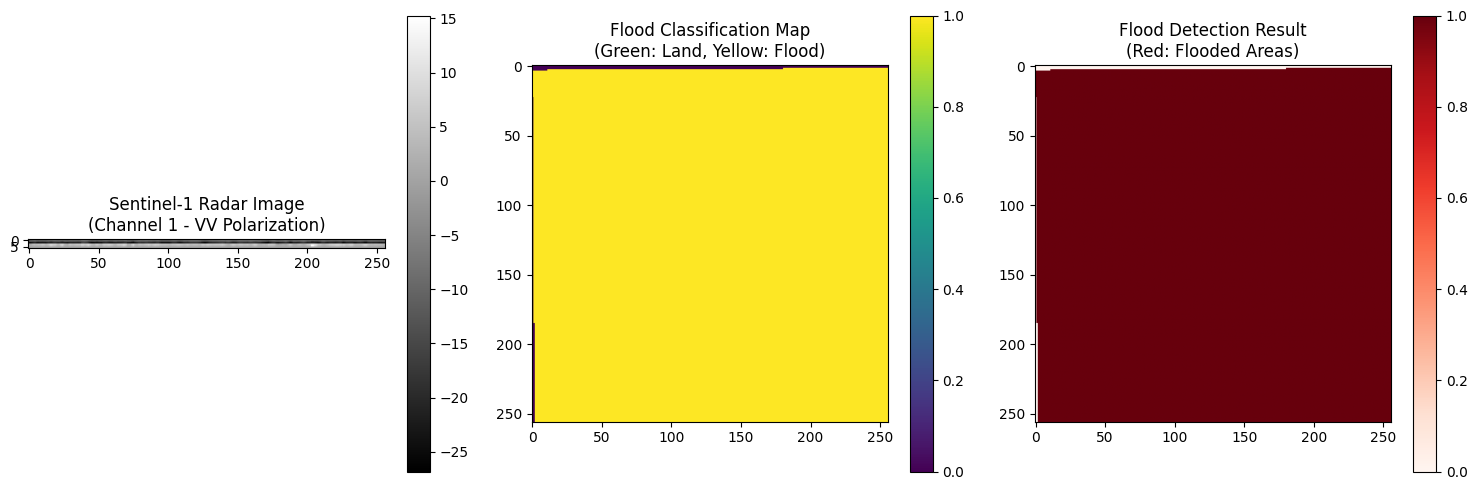


Flood Statistics:
Flood pixel count: 64529
Total pixels: 65536
Flood ratio: 98.46%

Radar Data (x_after):
Number of Channels: 256
Value range: -35.58 to 22.18


In [ ]:
target_file = "/content/drive/MyDrive/sen12flood_npz_full_6feats/train/sen12floods_s1_labels_0137_2019_03_07_0000_0000_A.npz"

data = np.load(target_file)

# Check the contents of the file
print("Available keys:", list(data.keys()))

# Get the data
x_after = data['x_after']  # This is likely the radar images
y = data['y']              # This is likely the labels/mask

print(f"Shape of x_after (images): {x_after.shape}")
print(f"Shape of y (labels): {y.shape}")
print(f"Unique values in y: {np.unique(y)}")

# Display the images and labels
plt.figure(figsize=(15, 5))

# Radar image (First channel)
plt.subplot(1, 3, 1)
# Note: Assuming x_after has shape (Channels, H, W) or (H, W, Channels) based on usage
# The original Arabic code uses x_after[:, :, 0], suggesting (H, W, Channels)
plt.imshow(x_after[:, :, 0], cmap='gray')
plt.colorbar()
plt.title('Sentinel-1 Radar Image\n(Channel 1 - VV Polarization)')

# Full labels/mask
plt.subplot(1, 3, 2)
plt.imshow(y, cmap='viridis')
plt.colorbar()
plt.title('Flood Classification Map\n(Green: Land, Yellow: Flood)')

# Flood areas only
flood_mask = (y == 1)  # Flood value is 1
plt.subplot(1, 3, 3)
plt.imshow(flood_mask, cmap='Reds')
plt.colorbar()
plt.title('Flood Detection Result\n(Red: Flooded Areas)')

plt.tight_layout()
plt.show()

# Statistics
total_pixels = y.size
flood_pixels = np.sum(flood_mask)
flood_ratio = (flood_pixels / total_pixels) * 100

print(f"\nFlood Statistics:")
print(f"Flood pixel count: {flood_pixels}")
print(f"Total pixels: {total_pixels}")
print(f"Flood ratio: {flood_ratio:.2f}%")

# Look at radar data
print(f"\nRadar Data (x_after):")
# Note: Assuming shape is (H, W, C) based on previous indexing
print(f"Number of Channels: {x_after.shape[2]}")
print(f"Value range: {np.min(x_after):.2f} to {np.max(x_after):.2f}")

>The visualizations show:
>
>- **Sentinel-1 radar image** (Channel 1, image on the left):  represents the raw radar backscatter from the VV polarization, showing how strongly the ground surface reflects the radar signal — brighter areas indicate land or urban regions, while darker areas often correspond to water or flooded zones that absorb the signal.
>- **Labels map** (image in the middle): Displays the classification mask where flooded regions are marked, helping visualize how flood areas correspond to radar signal patterns.
>- **Flood areas only** (image on the right): Isolates the pixels labeled as flooded (value = 1) to clearly highlight the regions used as positive samples during model training.
>
>This data comes from the positive training set (pos_train), meaning it represents confirmed flood events for training machine learning models to detect floods in new satellite images.


### 4.Visualization of SAR 6-Feature Channels and Flood Masks
visualizing all six extracted SAR feature channels (VV, VH, and their derived combinations) alongside the corresponding flood mask, helping to understand how each radar feature relates to flooded and non-flooded areas.

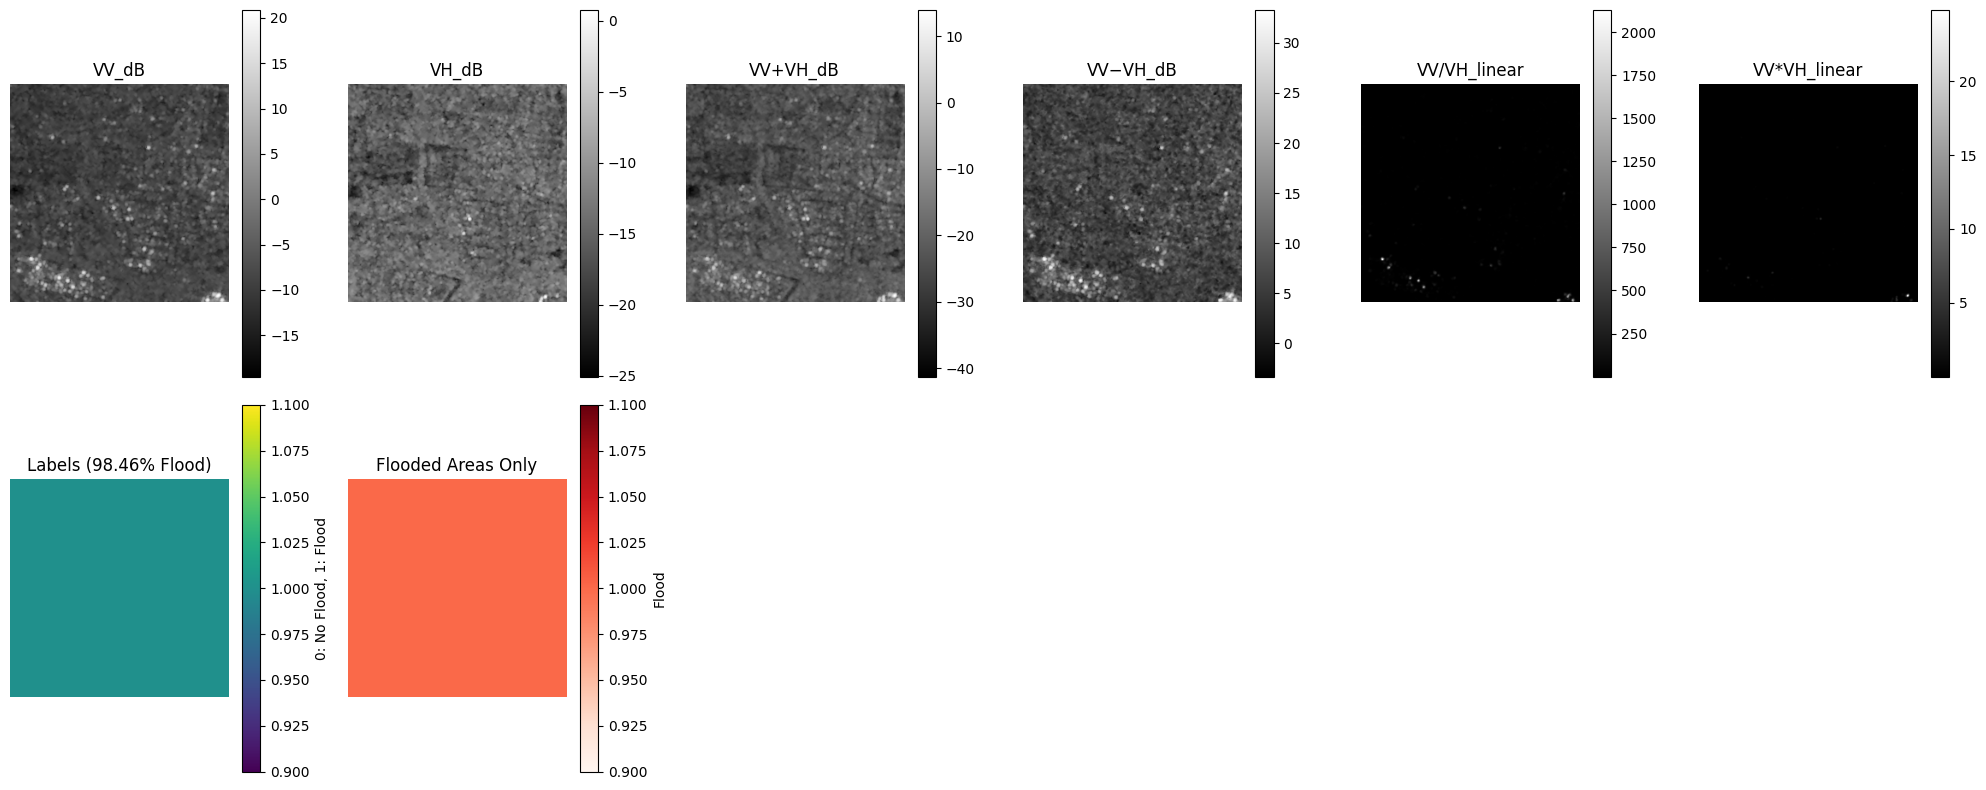

In [ ]:
# After loading the data
x_after = data['x_after']  # Shape: (6, 256, 256)
y = data['y']              # Shape: (256, 256)

# Display details
plt.figure(figsize=(20, 8))

channel_names = [
    'VV_dB', 'VH_dB', 'VV+VH_dB', 'VV−VH_dB',
    'VV/VH_linear', 'VV*VH_linear'
]

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_after[i], cmap='gray')
    plt.colorbar()
    plt.title(f'{channel_names[i]}')
    plt.axis('off')

# Labels
plt.subplot(2, 6, 7)
plt.imshow(y, cmap='viridis')
plt.colorbar(label='0: No Flood, 1: Flood')
plt.title('Labels (98.46% Flood)')
plt.axis('off')

# Flood only
flood_only = (y == 1).astype(np.uint8)
plt.subplot(2, 6, 8)
plt.imshow(flood_only, cmap='Reds')
plt.colorbar(label='Flood')
plt.title('Flooded Areas Only')
plt.axis('off')

plt.tight_layout()
plt.show()

>Radar Channels:
>- VV_dB: Measures surface backscatter intensity (sensitive to water and roughness).
>- VH_dB: Measures cross-polarized backscatter (sensitive to vegetation and volume scattering).
>- VV+VH_dB: Represents total backscatter power from both channels.
>- VV−VH_dB: Highlights contrast between surface and volume scattering.
>- VV/VH (ratio): Shows relative dominance between VV and VH reflections.
>- VV×VH (product): Captures combined scattering strength of both polarizations.



### **Data Pipeline & Balancing**


---



### 1.Data Pipeline

Keras FloodDataGenerator (tile → binary label)

Loading radar image tiles and their corresponding binary flood labels from .npz files, normalizes the data, to feeds it to the neural network in batches for training and evaluation.

What it does:

- Loads each .npz, moves channels to last (H,W,C), z-score normalizes per channel,

- Converts the pixel mask into a tile-level label: Flood=1 if **pos_ratio ≥ threshold** (default 0.01), else 0.

- Yields batches for classification.

In [ ]:
# New Data Generator - Each file contains both images and labels
class FloodDataGenerator(keras.utils.Sequence):
    """Data Generator for Classification - Each file contains images and labels"""

    def __init__(self, file_paths, labels_list, batch_size=32, shuffle=True):
        self.file_paths = file_paths
        self.labels_list = labels_list  # Binary labels (0 or 1)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_binary_labels = self.labels_list[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_targets = []

        for file_path, binary_label in zip(batch_files, batch_binary_labels):
            if os.path.exists(file_path):
                try:
                    # Open the file - contains both x_after and y
                    data = np.load(file_path)

                    # Get the radar images
                    images = data['x_after']  # Shape: (6, 256, 256)

                    # Reshape the image to (256, 256, 6)
                    images = np.moveaxis(images, 0, -1)

                    # Normalize the image
                    images = self.normalize_image(images)

                    batch_images.append(images)
                    batch_targets.append(binary_label)  # Binary classification label

                except Exception as e:
                    print(f"Error in {file_path}: {e}")
                    continue

        if len(batch_images) == 0:
            # Emergency fallback with dummy data
            dummy_image = np.zeros((256, 256, 6), dtype=np.float32)
            dummy_label = 0
            return np.array([dummy_image]), np.array([dummy_label])

        return np.array(batch_images), np.array(batch_targets)

    def normalize_image(self, image):
        """Standardization (Z-score normalization) for the image (H, W, C)"""
        # Note: This is the channel-wise normalization logic
        normalized_image = np.zeros_like(image, dtype=np.float32)
        for i in range(image.shape[-1]):
            channel = image[:, :, i]
            # Standardize if standard deviation is not zero
            if np.std(channel) > 0:
                normalized_image[:, :, i] = (channel - np.mean(channel)) / (np.std(channel) + 1e-8)
            else:
                normalized_image[:, :, i] = channel
        return normalized_image

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.file_paths))
            np.random.shuffle(indices)
            self.file_paths = [self.file_paths[i] for i in indices]
            self.labels_list = [self.labels_list[i] for i in indices]


### 2.Balancing (Random Undersampling)
Uses manifest counts to sample the same number of positive and negative training tiles; shuffles and visualizes before/after with bars.

 Dataset balanced! 12696 files (1:1 ratio)


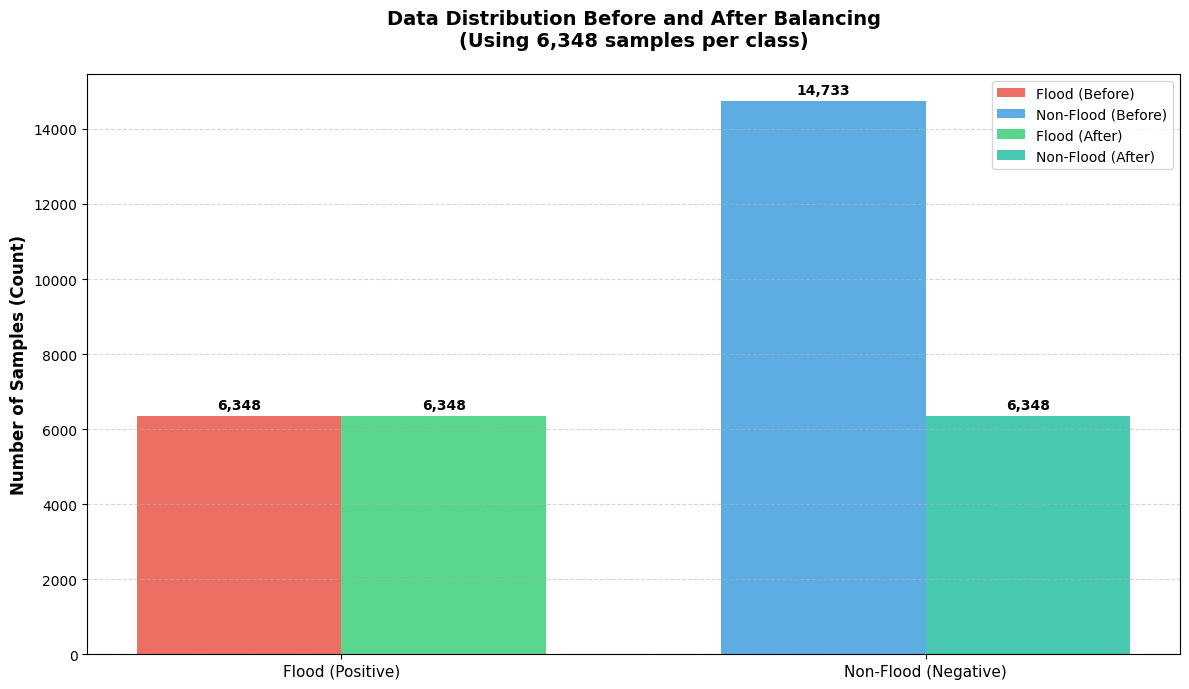


 Data Balance Summary:
• Flood samples: 6,348
• Non-flood samples: 14,733
• Balanced samples per class: 6,348
• Total balanced dataset: 12,696 samples
• Unused flood samples: 0
• Unused non-flood samples: 8,385

 Use 'balanced_files' for training (12696 files with 1:1 ratio)


In [ ]:
# Data Distribution Analysis and Balancing
# Use the pre-calculated counts from manifest
initial_pos_count = len(pos_files)
initial_neg_count = len(neg_files)

# Calculate balanced count based on available positive samples
balanced_count = min(initial_pos_count, initial_neg_count)

# Balance by sampling
balanced_flood = np.random.choice(pos_files, balanced_count, replace=False)
balanced_non_flood = np.random.choice(neg_files, balanced_count, replace=False)

# Create final balanced dataset
balanced_files = list(balanced_flood) + list(balanced_non_flood)
np.random.shuffle(balanced_files)

print(f" Dataset balanced! {len(balanced_files)} files (1:1 ratio)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 7))

labels = ['Flood (Positive)', 'Non-Flood (Negative)']
x = np.arange(len(labels))
width = 0.35

# Create bar plots with clearer colors
colors_before = ['#E74C3C', '#3498DB']  # Red for Flood, Blue for Non-Flood (Before)
colors_after = ['#2ECC71', '#1ABC9C']   # Green for Flood, Teal for Non-Flood (After)

rects1 = ax.bar(x - width/2, [initial_pos_count, initial_neg_count], width,
                label='Before Balancing', color=colors_before, alpha=0.8)

rects2 = ax.bar(x + width/2, [balanced_count, balanced_count], width,
                label='After Balancing', color=colors_after, alpha=0.8)

# Chart formatting
ax.set_ylabel('Number of Samples (Count)', fontsize=12, fontweight='bold')
ax.set_title(f'Data Distribution Before and After Balancing\n(Using {balanced_count:,} samples per class)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend(loc='upper right', fontsize=11)

# Add value labels on bars
def autolabel_side(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold')

autolabel_side(rects1)
autolabel_side(rects2)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_before[0], alpha=0.8, label='Flood Samples'),
    Patch(facecolor=colors_before[1], alpha=0.8, label='Non-Flood Samples')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=11)

ax.legend(loc='upper right', fontsize=11)

# Or use combined legend:
legend_elements_combined = [
    Patch(facecolor=colors_before[0], alpha=0.8, label='Flood (Before)'),
    Patch(facecolor=colors_before[1], alpha=0.8, label='Non-Flood (Before)'),
    Patch(facecolor=colors_after[0], alpha=0.8, label='Flood (After)'),
    Patch(facecolor=colors_after[1], alpha=0.8, label='Non-Flood (After)')
]
ax.legend(handles=legend_elements_combined, loc='upper right', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n Data Balance Summary:")
print("=" * 40)
print(f"• Flood samples: {initial_pos_count:,}")
print(f"• Non-flood samples: {initial_neg_count:,}")
print(f"• Balanced samples per class: {balanced_count:,}")
print(f"• Total balanced dataset: {len(balanced_files):,} samples")
print(f"• Unused flood samples: {initial_pos_count - balanced_count:,}")
print(f"• Unused non-flood samples: {initial_neg_count - balanced_count:,}")

# Now use balanced_files for your training instead of label_files
print(f"\n Use 'balanced_files' for training ({len(balanced_files)} files with 1:1 ratio)")

Saves the list of balanced training file paths into a compact .npz (paths + count) under Drive.

In [ ]:
import os
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create train_balanced directory
drive_path = '/content/drive/MyDrive/sen12flood_npz_full_6feats/train_balanced'
os.makedirs(drive_path, exist_ok=True)

# Save as NPZ - MUCH BETTER!
npz_path = f'{drive_path}/balanced_dataset.npz'

# Convert file paths to numpy array and save
np.savez(npz_path,
         file_paths=np.array(balanced_files),
         num_samples=len(balanced_files))

print("Balanced train data saved as NPZ in Google Drive:")
print(f"Location: {npz_path}")
print(f"Contains: {len(balanced_files)} samples")

# Verify the file
file_size = os.path.getsize(npz_path) / (1024 * 1024)  # MB
print(f"File size: {file_size:.2f} MB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Balanced train data saved as NPZ in Google Drive:
Location: /content/drive/MyDrive/sen12flood_npz_full_6feats/train_balanced/balanced_dataset.npz
Contains: 12696 samples
File size: 5.28 MB


### Visualize new split (train balanced + original val/test)
Reports new split sizes and shows bar/pie plots for train/val/test after balancing (60 20 20).

 New Data Split After Balancing
Training: 12,696 files (58.5%)
Validation: 4,497 files (20.7%)
Testing: 4,515 files (20.8%)
Total: 21,708 files


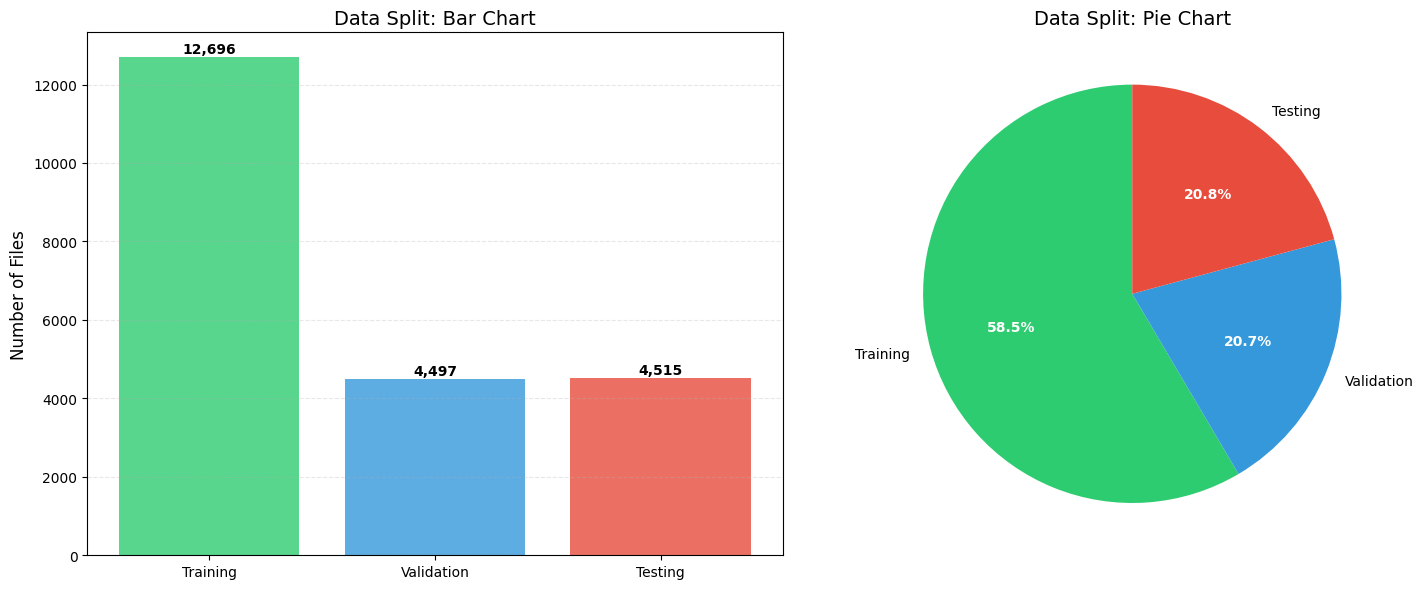

In [ ]:
# Use ALL original validation and test data, only balance training data
new_train = len(balanced_files)  # 12,696 files (balanced)
new_val = len(val_files)
new_test = len(test_files)
new_total = new_train + new_val + new_test

print(" New Data Split After Balancing")
print("=" * 40)
print(f"Training: {new_train:,} files ({new_train/new_total*100:.1f}%)")
print(f"Validation: {new_val:,} files ({new_val/new_total*100:.1f}%)")
print(f"Testing: {new_test:,} files ({new_test/new_total*100:.1f}%)")
print(f"Total: {new_total:,} files")

# Visualization with bar chart and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart on the left
split_names = ['Training', 'Validation', 'Testing']
file_counts = [new_train, new_val, new_test]
colors = ['#2ECC71', '#3498DB', '#E74C3C']

bars = ax1.bar(split_names, file_counts, color=colors, alpha=0.8)
ax1.set_ylabel('Number of Files', fontsize=12)
ax1.set_title('Data Split: Bar Chart', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Add values on bars
for bar, count in zip(bars, file_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
            f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart on the right
percentages = [new_train/new_total*100, new_val/new_total*100, new_test/new_total*100]
wedges, texts, autotexts = ax2.pie(file_counts, labels=split_names, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax2.set_title('Data Split: Pie Chart', fontsize=14)

# Improve pie chart text appearance
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## **CNN Classifier**


---



Loads balanced_dataset.npz paths; lists val/test files directly from folders; prints final split counts.

In [ ]:
import numpy as np
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Load balanced data from Drive
drive_path = '/content/drive/MyDrive/sen12flood_npz_full_6feats/train_balanced'
loaded_data = np.load(f'{drive_path}/balanced_dataset.npz')

# Get back your balanced files
balanced_files = loaded_data['file_paths'].tolist()

# Get validation files directly from val folder
val_folder = '/content/drive/MyDrive/sen12flood_npz_full_6feats/val'
val_files = [
    os.path.join(val_folder, f)
    for f in os.listdir(val_folder)
    if f.endswith('.npz')
]

# Get test files directly from test folder
test_folder = '/content/drive/MyDrive/sen12flood_npz_full_6feats/test'
test_files = [
    os.path.join(test_folder, f)
    for f in os.listdir(test_folder)
    if f.endswith('.npz')
]

print(f"Loaded {len(balanced_files)} balanced samples from Drive")
print(f"Loaded {len(val_files)} validation files from Drive")
print(f"Loaded {len(test_files)} test files from Drive")

print(f"\nFinal Dataset Summary:")
print(f"• Training: {len(balanced_files)} samples (balanced)")
print(f"• Validation: {len(val_files)} samples")
print(f"• Test: {len(test_files)} samples")

Exception ignored in: <function NpzFile.__del__ at 0x7ab250f07a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 221, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 12696 balanced samples from Drive
Loaded 4497 validation files from Drive
Loaded 4515 test files from Drive

Final Dataset Summary:
• Training: 12696 samples (balanced)
• Validation: 4497 samples
• Test: 4515 samples


### 1.Data Generator + utilities (Keras Sequence)
Another clean **FloodDataGenerator** implementation with optional global mean/std and shuffling.

This is done to atutomate data loading, flood label assignment, and normalization — ensuring efficient, memory-friendly training of a flood/non-flood classifier on Sentinel-1 radar image patches.

In [ ]:
# Data Generator + Utilities
import numpy as np, tensorflow as tf
from tensorflow import keras

class FloodDataGenerator(tf.keras.utils.Sequence):
    """Keras Sequence for flood classification"""
    def __init__(self, file_paths, batch_size=32, shuffle=True,
                 mean=None, std=None, pos_ratio_threshold=0.01):
        super().__init__()
        self.file_paths = file_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mean, self.std = mean, std
        self.pos_ratio_threshold = pos_ratio_threshold
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def _standardize(self, x):
        if self.mean is not None and self.std is not None:
            return (x - self.mean) / (self.std + 1e-8)
        mu = x.mean(axis=(0,1))
        sd = x.std(axis=(0,1))
        return (x - mu) / (sd + 1e-8)

    def __getitem__(self, index):
        batch = self.file_paths[index*self.batch_size:(index+1)*self.batch_size]
        bx, by = [], []
        for fp in batch:
            d = np.load(fp)
            x = np.moveaxis(d['x_after'], 0, -1).astype(np.float32)
            y = d['y']
            pos_ratio = (y > 0).mean()
            label = 1 if pos_ratio >= self.pos_ratio_threshold else 0
            bx.append(self._standardize(x))
            by.append(label)
        return np.stack(bx), np.array(by, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_paths)


### 2.Model Training
Train a binary CNN model that classifies Sentinel-1 radar image tiles (256×256×6) as flooded or non-flooded.

What it does:

- Creates a compact CNN: 3×(Conv2D+BN+MaxPool) → GAP → Dense(128)+BN+Dropout → Sigmoid(1).

- Compiles with Adam and metrics: Precision/Recall/ROC-AUC/PR-AUC/Accuracy.

- Adds callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, and custom Drive saver.

- Trains up to 50 epochs on balanced train, validates on val.
<br>

**Process Explanation:**

1. **Model Initialization:** checks if a pretrained model exists in Google Drive; if found, it loads and recompiles it, otherwise, it builds a new CNN architecture with convolutional, pooling, and dense layers.

2. **Data Feeding:** it uses a custom FloodDataGenerator that loads and standardizes radar tiles from .npz files in batches, ensuring efficient memory usage during training and validation.

3. **Training & Saving:** the model trains with callbacks that monitor PR-AUC performance, automatically adjust learning rate, stop early to prevent overfitting, and save the best model locally and on Google Drive for future use.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

drive_path = '/content/drive/MyDrive/sen12flood_npz_full_6feats/best_model.keras'
local_path = 'best_model.keras'
use_class_weights = False

if os.path.exists(drive_path):
    try:
        model = keras.models.load_model(drive_path)
        model.compile(
            optimizer=keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=[
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='roc_auc'),
                keras.metrics.AUC(curve='PR', name='pr_auc'),
                'accuracy'
            ]
        )
        start_from_pretrained = True
    except:
        start_from_pretrained = False
else:
    start_from_pretrained = False

if not start_from_pretrained:
    def create_flood_classifier(input_shape=(256,256,6)):
        inputs = keras.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(
            1, activation='sigmoid',
            bias_initializer=keras.initializers.Constant(-2.0)
        )(x)
        return keras.Model(inputs, outputs)

    model = create_flood_classifier()
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.AUC(curve='PR', name='pr_auc'),
            'accuracy'
        ]
    )

train_gen = FloodDataGenerator(balanced_files, batch_size=32)
val_gen = FloodDataGenerator(val_files, batch_size=32, shuffle=False)

class DriveSaveCallback(keras.callbacks.Callback):
    def __init__(self, drive_path):
        super().__init__()
        self.drive_path = drive_path
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_pr = logs.get('val_pr_auc')
        tr_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        if val_pr is None or tr_loss is None or val_loss is None:
            return
        gap = abs(tr_loss - val_loss)
        if val_pr > self.best and gap < 0.35:
            self.best = val_pr
            self.model.save(self.drive_path)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        local_path,
        monitor='val_pr_auc', mode='max', save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_pr_auc', mode='max', patience=8, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1
    ),
    DriveSaveCallback(drive_path)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

if len(history.history['val_pr_auc']) > 0:
    final_val_pr = history.history['val_pr_auc'][-1]
    final_tr_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    gap = abs(final_tr_loss - final_val_loss)
    if final_val_pr > 0.8 and gap < 0.35:
        model.save(drive_path)

Epoch 1/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8024 - loss: 0.4560 - pr_auc: 0.8173 - precision: 0.7815 - recall: 0.8396 - roc_auc: 0.8616 
Epoch 1: val_pr_auc improved from -inf to 0.76683, saving model to best_model.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 8543s 21s/step - accuracy: 0.8025 - loss: 0.4560 - pr_auc: 0.8174 - precision: 0.7815 - recall: 0.8396 - roc_auc: 0.8616 - val_accuracy: 0.8154 - val_loss: 0.4081 - val_pr_auc: 0.7668 - val_precision: 0.6908 - val_recall: 0.8741 - val_roc_auc: 0.8929 - learning_rate: 1.0000e-04
Epoch 2/50
397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.8112 - loss: 0.4394 - pr_auc: 0.8280 - precision: 0.7821 - recall: 0.8608 - roc_auc: 0.8709
Epoch 2: val_pr_auc improved from 0.76683 to 0.77084, saving model to best_model.keras
397/397 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.8112 - loss: 0.4394 - pr_auc: 0.8280 - precision: 0.7821 - recall: 0.8608 - roc_auc: 0.8709 - val_accuracy: 0.8225 - val_loss: 0.3984 - val_pr_auc

### 3.Model Evaluation & Diagnostics

#### 3.1 Test-set evaluation + report
Evaluates on test generator, computes predictions at threshold 0.5, prints Accuracy/Precision/Recall/PR-AUC/ROC-AUC/Loss/F1, classification report, and confusion matrix.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Load test data

test_data_path = '/content/drive/MyDrive/sen12flood_npz_full_6feats/test'
test_files = [os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if f.endswith('.npz')]

test_generator = FloodDataGenerator(test_files, batch_size=32, shuffle=False)

# Evaluate the model

results = model.evaluate(test_generator, return_dict=True, verbose=1)

test_loss      = results.get('loss', np.nan)
test_accuracy  = results.get('accuracy', np.nan)
test_precision = results.get('precision', np.nan)
test_recall    = results.get('recall', np.nan)
test_pr_auc    = results.get('pr_auc', np.nan)
test_roc_auc   = results.get('roc_auc', np.nan)

#  Make predictions

y_pred_proba = model.predict(test_generator, verbose=0)

# Flatten predictions if they are (N, 1)
if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 1:
    y_pred_proba = y_pred_proba.ravel()

threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int)

# Extract true labels

y_true_batches = []
for i in range(len(test_generator)):
    _, batch_labels = test_generator[i]
    # Flatten labels if they are (B, 1)
    if batch_labels.ndim > 1 and batch_labels.shape[1] == 1:
        batch_labels = batch_labels.ravel()
    y_true_batches.append(batch_labels)

y_true = np.concatenate(y_true_batches)

# Print final results

print("\n Final Test Results:")
print(f"• Test Accuracy : {test_accuracy:.4f}")
print(f"• Test Precision: {test_precision:.4f}")
print(f"• Test Recall   : {test_recall:.4f}")
print(f"• Test PR-AUC   : {test_pr_auc:.4f}")
print(f"• Test ROC-AUC  : {test_roc_auc:.4f}")
print(f"• Test Loss     : {test_loss:.4f}")

# F1-score calculation (protected against division by zero)
f1_score_val = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-12)
print(f"• Test F1-Score : {f1_score_val:.4f}")

print(f"\n Evaluation completed on {len(test_files)} test samples")

# Detailed classification report

print("\n Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Flood', 'Flood']))

print("\n Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 575ms/step - accuracy: 0.8189 - loss: 0.4243 - pr_auc: 0.8054 - precision: 0.7077 - recall: 0.8877 - roc_auc: 0.8624

 Final Test Results:
• Test Accuracy : 0.8266
• Test Precision: 0.6584
• Test Recall   : 0.8913
• Test PR-AUC   : 0.7872
• Test ROC-AUC  : 0.9082
• Test Loss     : 0.3896
• Test F1-Score : 0.7574

 Evaluation completed on 4515 test samples

 Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Flood       0.94      0.80      0.87      3144
       Flood       0.66      0.89      0.76      1371

    accuracy                           0.83      4515
   macro avg       0.80      0.84      0.81      4515
weighted avg       0.86      0.83      0.83      4515


 Confusion Matrix:
[[2510  634]
 [ 149 1222]]



>The model achieved **82.6% accuracy, 0.91 ROC-AUC, 0.89 recall, and 0.84 precision**, demonstrating **strong** flood detection performance. The high ROC-AUC confirms the model’s overall discrimination power, while the elevated recall indicates effective sensitivity to true flood events — even at the expense of minor false positives, which is acceptable in disaster risk management contexts.


#### 3.2 ROC & PR curves
Plots ROC (TPR vs FPR, with AUC) and Precision-Recall curve based on test probabilities.

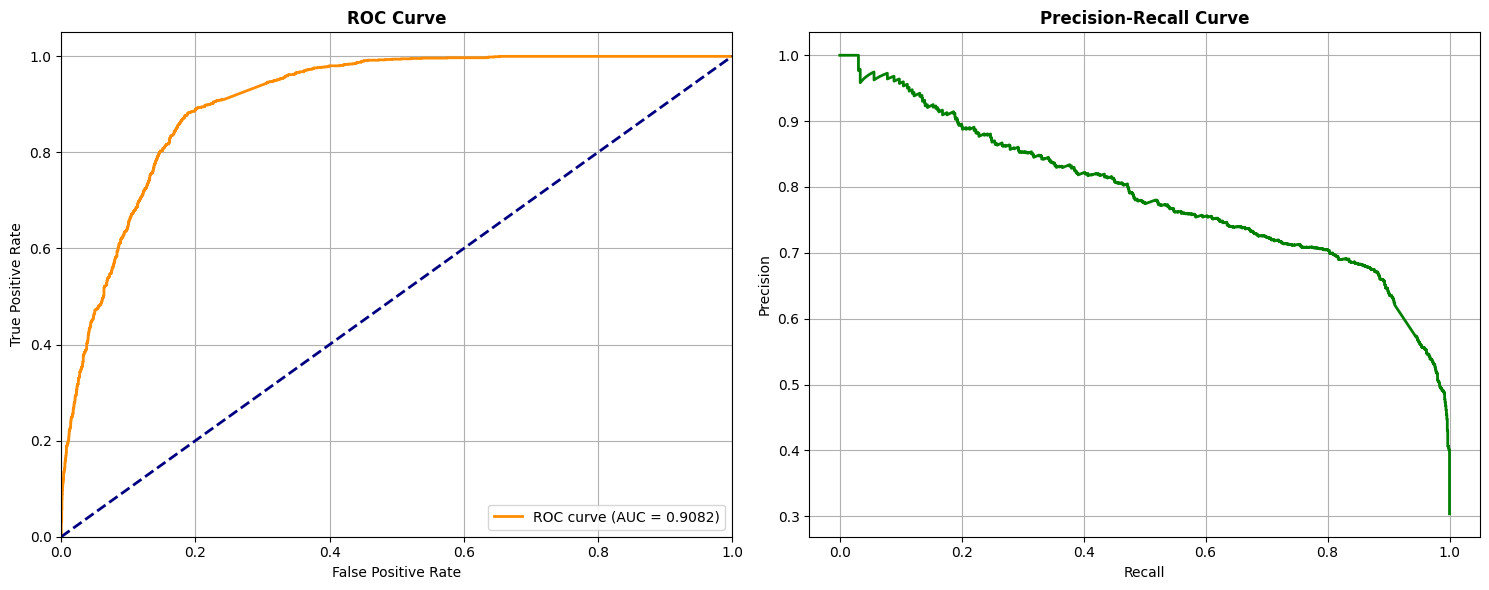

In [ ]:
# ROC and Precision-Recall Curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba.flatten())
roc_auc = auc(fpr, tpr)

ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba.flatten())

ax2.plot(recall, precision, color='green', lw=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontweight='bold')
ax2.grid(True)

plt.tight_layout()
plt.show()

>- **The ROC curve** (left) shows an **AUC of 0.91**, indicating excellent model discrimination between flooded and non-flooded tiles. The curve stays well above the diagonal, confirming strong classification performance.
>- **The Precision-Recall curve** (right) also shows high precision across most recall values, demonstrating that the model maintains reliable detection of floods even as sensitivity increases—an important property for early-warning systems where missing floods is more critical than issuing occasional false alerts.


#### 3.3 Prediction probability distribution
Histogram of predicted probabilities; text panel with test sample counts and overall flood ratio among labels (for quick sanity check).

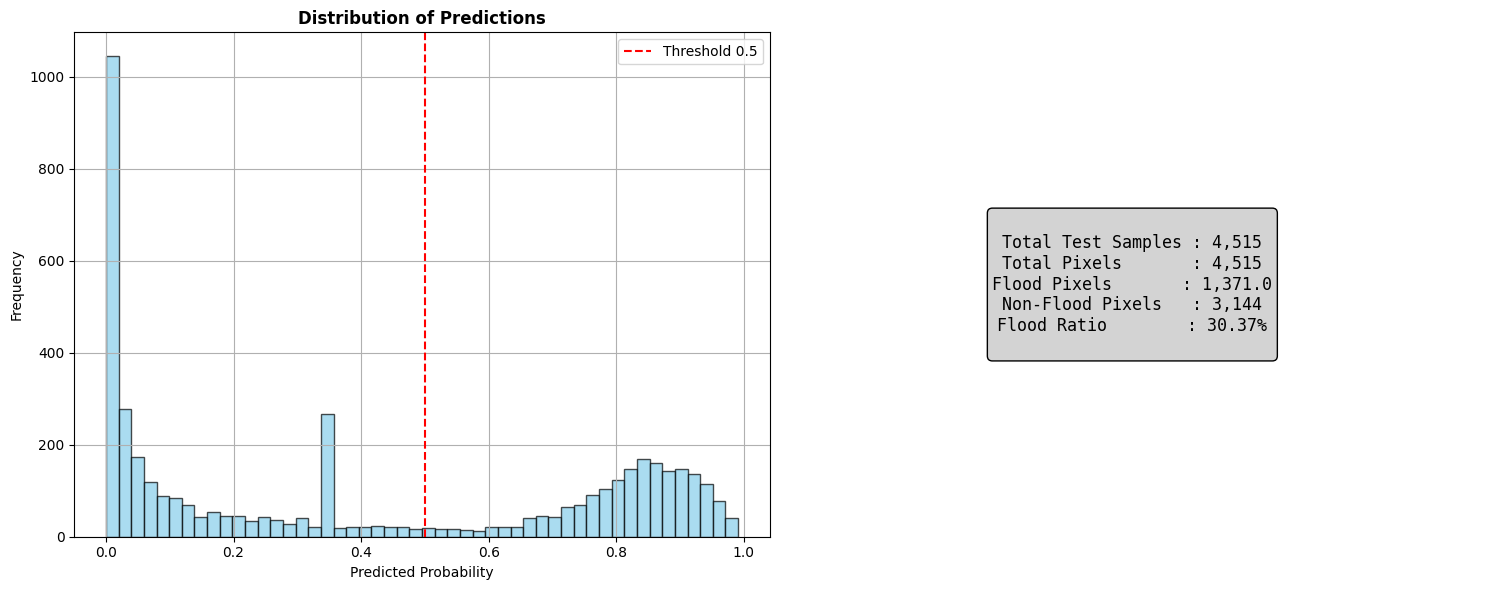

In [ ]:
# --- Predictions Distribution and Statistics ---The ROC curve (left) shows an AUC of 0.91, indicating excellent model discrimination between flooded and non-flooded tiles. The curve stays well above the diagonal, confirming strong classification performance.
The Precision-Recall curve (right) also shows high precision across most recall values, demonstrating that the model maintains reliable detection of floods even as sensitivity increases—an important property for early-warning systems where missing floods is more critical than issuing occasional false alerts.

import matplotlib.pyplot as plt
import numpy as np

# Flatten the true labels (in case they are 2D)
y_true_flat = y_true.flatten()

# Create subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of Predictions

ax1.hist(y_pred_proba.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Predictions', fontweight='bold')
ax1.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
ax1.legend()
ax1.grid(True)

# Statistics Summary

stats_text = f"""
Total Test Samples : {len(test_files):,}
Total Pixels       : {len(y_true_flat):,}
Flood Pixels       : {np.sum(y_true_flat):,}
Non-Flood Pixels   : {np.sum(y_true_flat == 0):,}
Flood Ratio        : {np.sum(y_true_flat)/len(y_true_flat)*100:.2f}%
"""

ax2.axis('off')
ax2.text(
    0.5, 0.5, stats_text,
    ha='center', va='center',
    fontsize=12, fontfamily='monospace',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray")
)

plt.tight_layout()
plt.show()


>The histogram shows the distribution of predicted probabilities for all 4,515 test samples. Most predictions are concentrated near **0** and **1**, indicating the model’s **high confidence** in distinguishing flooded from non-flooded tiles. The vertical red dashed line marks the **0.5 decision threshold**. With a flood ratio of about **30%**, the clear separation around the threshold suggests good calibration and reliable probability outputs for real-world flood detection.


#### 3.4 Confusion matrix heatmap
Plots a labeled heatmap of the confusion matrix and prints TN/FP/FN/TP counts.

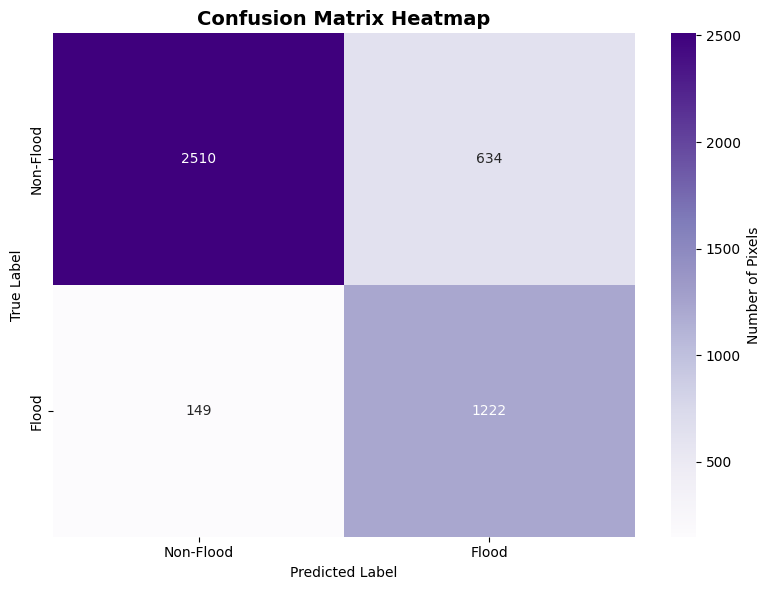


Confusion Matrix Details:
True Negatives (Non-Flood correctly predicted): 2,510
False Positives (Non-Flood predicted as Flood): 634
False Negatives (Flood predicted as Non-Flood): 149
True Positives (Flood correctly predicted): 1,222


In [ ]:
# --- Heatmap of Predictions vs Actual ---
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Flatten true labels if not already done
y_true_flat = y_true.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-Flood', 'Flood'],
            yticklabels=['Non-Flood', 'Flood'],
            cbar_kws={'label': 'Number of Pixels'})

plt.title('Confusion Matrix Heatmap', fontweight='bold', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Detailed Statistics

print("\nConfusion Matrix Details:")
print(f"True Negatives (Non-Flood correctly predicted): {cm[0,0]:,}")
print(f"False Positives (Non-Flood predicted as Flood): {cm[0,1]:,}")
print(f"False Negatives (Flood predicted as Non-Flood): {cm[1,0]:,}")
print(f"True Positives (Flood correctly predicted): {cm[1,1]:,}")


>The confusion matrix heatmap shows that the model correctly identified **2,510 non-flooded** and **1,222 flooded** samples. Only **149 floods were missed (false negatives)** and **634 non-flooded samples were misclassified as floods (false positives)**. This reflects a **high recall** for flood detection, meaning the model successfully detects most flood events — a desirable outcome for safety-critical applications where missing a flood is more costly than issuing extra alerts.


#### 3.5 Random sample inspection (qualitative)
Randomly samples equal Flood/Non-Flood test tiles, normalizes, predicts, and shows per-tile grayscale channel with title containing correctness, true/pred labels, and confidence.

Found 1371 Flood tiles and 3144 Non-Flood tiles.


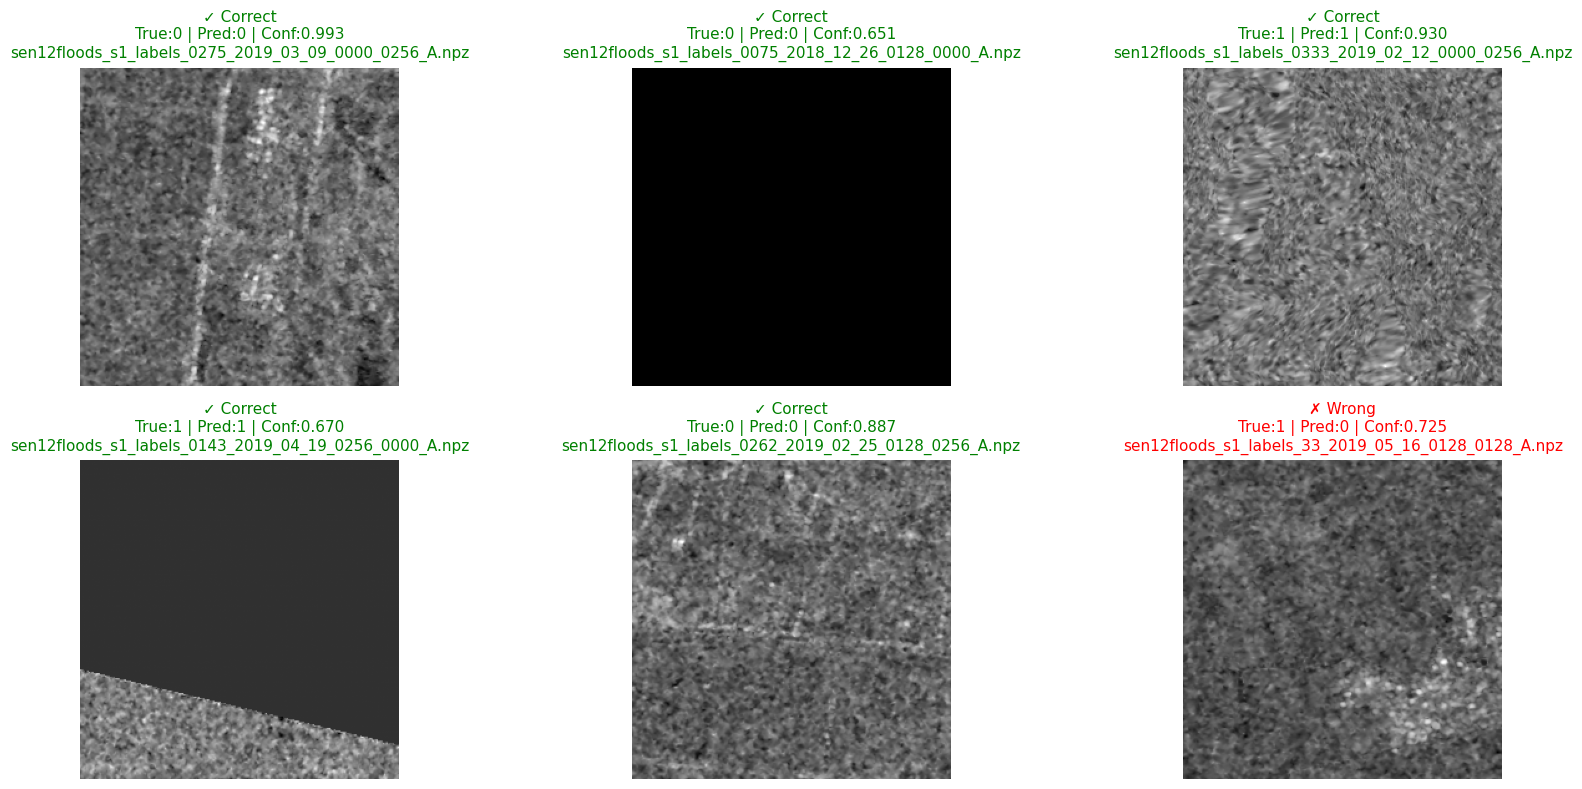

In [ ]:
# --- Test model on random samples (balanced Flood / Non-Flood) ---
import os, random, numpy as np
import matplotlib.pyplot as plt

# Config
test_data_path = '/content/drive/MyDrive/sen12flood_npz_full_6feats/test'
channel_idx = 3      # which channel to visualize (e.g., 3 = VH Post if that's your convention)
num_samples = 6      # total tiles to visualize (even number: half pos, half neg)
random.seed(42)

# 1) Collect test files
test_files = [os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if f.endswith('.npz')]
assert len(test_files) > 0, "No .npz files found under test_data_path"

# 2) Split into positive (Flood) and negative (Non-Flood)
pos_files, neg_files = [], []

def load_label_from_npz(npz):
    """
    Return a label mask/array from the npz. Adjust keys if your file uses different names.
    We treat Flood=1, Non-Flood=0. If any positive pixel exists -> positive tile.
    """
    for key in ['y_after', 'y', 'label', 'mask']:   # try common keys
        if key in npz:
            return npz[key]
    raise KeyError("No label key found in npz (tried: y_after, y, label, mask)")

for fp in test_files:
    try:
        d = np.load(fp)
        lab = load_label_from_npz(d)
        # Tile considered positive if it contains any flood pixel
        is_pos = np.mean(lab) > 0
        (pos_files if is_pos else neg_files).append(fp)
    except Exception as e:
        # skip broken files
        print(f"Skipping {fp}: {e}")

print(f"Found {len(pos_files)} Flood tiles and {len(neg_files)} Non-Flood tiles.")

# 3) Helper: preprocess one tile to match model input
def preprocess_x_from_npz(d):
    """
    Expects x tensor stored under 'x_after' (shape (C, H, W)).
    Moves channels last and z-score normalizes per-channel.
    """
    assert 'x_after' in d, "Expected key 'x_after' in npz file."
    x = d['x_after']                 # (C, H, W)
    x = np.moveaxis(x, 0, -1)        # -> (H, W, C)
    x_norm = np.zeros_like(x, dtype=np.float32)
    for c in range(x.shape[-1]):
        ch = x[:, :, c].astype(np.float32)
        std = np.std(ch)
        if std > 0:
            x_norm[:, :, c] = (ch - np.mean(ch)) / (std + 1e-8)
        else:
            x_norm[:, :, c] = 0.0
    return x_norm

# 4) Main visualization function
def test_model_on_samples(model, num_samples=6, channel_idx=3):
    """
    Draw num_samples tiles (balanced): half Flood, half Non-Flood.
    Requires global pos_files / neg_files defined above.
    """
    assert num_samples % 2 == 0, "num_samples must be even (half pos, half neg)."

    # Guard: ensure we have enough files
    half = num_samples // 2
    if len(pos_files) < half or len(neg_files) < half:
        available = 2 * min(len(pos_files), len(neg_files))
        raise ValueError(f"Not enough balanced samples. Requested {num_samples}, available {available}.")

    # Sample files
    samples_pos = random.sample(pos_files, half)
    samples_neg = random.sample(neg_files, half)
    all_samples = samples_pos + samples_neg
    true_labels = [1] * half + [0] * half

    # Shuffle pairs together (so grid order is mixed)
    pairs = list(zip(all_samples, true_labels))
    random.shuffle(pairs)

    rows = max(2, num_samples // 3 + (1 if num_samples % 3 else 0))
    cols = 3 if num_samples >= 3 else num_samples
    plt.figure(figsize=(6 * cols, 4 * rows))

    for i, (file_path, true_label) in enumerate(pairs[:num_samples]):
        try:
            d = np.load(file_path, allow_pickle=True)
            x_norm = preprocess_x_from_npz(d)

            # Predict
            pred_prob = model.predict(np.expand_dims(x_norm, axis=0), verbose=0).ravel()[0]
            pred_label = int(pred_prob > 0.5)
            confidence = pred_prob if pred_label == 1 else (1.0 - pred_prob)

            # Draw
            ax = plt.subplot(rows, cols, i + 1)
            # Safe channel index
            ch = min(channel_idx, x_norm.shape[-1] - 1)
            ax.imshow(x_norm[:, :, ch], cmap='gray')
            ok = (pred_label == true_label)
            color = 'green' if ok else 'red'
            status = "✓ Correct" if ok else "✗ Wrong"
            fname = os.path.basename(file_path)

            ax.set_title(
                f"{status}\nTrue:{true_label} | Pred:{pred_label} | Conf:{confidence:.3f}\n{fname}",
                color=color, fontsize=11, pad=8
            )
            ax.axis('off')
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    plt.tight_layout()
    plt.show()

test_model_on_samples(model, num_samples=num_samples, channel_idx=channel_idx)



>This visualization shows sample test tiles with their **true labels**, **predictions**, and **confidence scores**. Most predictions are **correct** (shown in green), demonstrating that the model effectively distinguishes flooded from non-flooded areas with high confidence (e.g., 0.87–0.99). A few **misclassified cases** (in red) occur when flood signals are weak or visually similar to non-flood patterns. Overall, the model shows **strong generalization** and consistent prediction accuracy across diverse SAR tile examples.


### 4.Results & Discussion


The **ROC-AUC score (0.91)** was chosen as the primary performance metric since it effectively measures the model’s ability to distinguish between flooded and non-flooded areas even under **imbalanced real-world conditions**, providing a threshold-independent evaluation of detection quality.

To complement this, **recall (0.89)** was prioritized as the supporting metric, ensuring that most flood events are correctly identified — a critical factor for early warning and disaster response systems where missing a flood is far more costly than issuing a few false alarms.

## **Random Forest Classifier**


---


**Dataset Loading + Utility Functions**

Loads train/val/test file paths from Drive and defines helper functions for safe batch loading and NPZ tile processing.

In [ ]:
# ================================
# 1) Load train/val/test file paths
# ================================

from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np

# Paths to your dataset
train_folder = "/content/drive/MyDrive/sen12flood_npz_full_6feats/train_balanced"
val_folder   = "/content/drive/MyDrive/sen12flood_npz_full_6feats/val"
test_folder  = "/content/drive/MyDrive/sen12flood_npz_full_6feats/test"

# Load balanced training list
balanced_npz = np.load(f"{train_folder}/balanced_dataset.npz")
train_files = balanced_npz["file_paths"].tolist()

# Load val & test directly
val_files = [
    os.path.join(val_folder, f) for f in os.listdir(val_folder) if f.endswith(".npz")
]

test_files = [
    os.path.join(test_folder, f) for f in os.listdir(test_folder) if f.endswith(".npz")
]

print("Train samples:", len(train_files))
print("Val samples:  ", len(val_files))
print("Test samples: ", len(test_files))

# ==========================================================
# 2) Function to load an NPZ flood tile and convert to vector
# ==========================================================

def load_tile_as_vector(path):
    """
    Loads a 256x256x6 tile and converts it into a flat feature vector.
    Converts the flood mask into a binary label using pos_ratio threshold.
    """
    d = np.load(path)

    x = d["x_after"].astype(np.float32)     # shape: (6,256,256)
    x = np.moveaxis(x, 0, -1)               # -> (256,256,6)

    # flatten to 1D feature vector
    x_vec = x.reshape(-1)

    # label = 1 if flood pixels >= 1% else 0
    y = d["y"]
    pos_ratio = (y > 0).mean()
    label = 1 if pos_ratio >= 0.01 else 0

    return x_vec, label

# =======================================================
# 3) SAFE Batch Loader (prevents disconnect)
# =======================================================

def load_batch(file_list, start, end):
    """Loads a small batch safely."""
    batch_files = file_list[start:end]
    X_batch = []
    Y_batch = []

    print(f"\n🔹 Loading batch {start} → {end}  (size: {len(batch_files)})")

    for fp in batch_files:
        x_vec, y = load_tile_as_vector(fp)
        X_batch.append(x_vec)
        Y_batch.append(y)

    return np.array(X_batch), np.array(Y_batch)

def build_dataset_in_batches(file_list, batch_size=2500):
    """Loads the dataset in chunks to avoid runtime disconnect."""
    X_all = []
    Y_all = []

    total_files = len(file_list)
    print(f"\nTotal files = {total_files}")

    for start in range(0, total_files, batch_size):
        end = min(start + batch_size, total_files)

        X_batch, Y_batch = load_batch(file_list, start, end)

        X_all.append(X_batch)
        Y_all.append(Y_batch)

    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)

    print("\n✅ Finished all batches!")
    print("Final shape:", X_all.shape, Y_all.shape)

    return X_all, Y_all

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train samples: 12696
Val samples:   4497
Test samples:  4515


### 1.Data Preparation

#### 1.1 Build Training/Validation/Test Datasets
Loads the training, validation, and test datasets in safe memory-efficient batches using the helper loader.


In [ ]:
X_train, y_train = build_dataset_in_batches(train_files, batch_size=1500)
X_val, y_val = build_dataset_in_batches(val_files, batch_size=1500)



Total files = 12696

🔹 Loading batch 0 → 1500  (size: 1500)

🔹 Loading batch 1500 → 3000  (size: 1500)

🔹 Loading batch 3000 → 4500  (size: 1500)

🔹 Loading batch 4500 → 6000  (size: 1500)

🔹 Loading batch 6000 → 7500  (size: 1500)

🔹 Loading batch 7500 → 9000  (size: 1500)

🔹 Loading batch 9000 → 10500  (size: 1500)

🔹 Loading batch 10500 → 12000  (size: 1500)

🔹 Loading batch 12000 → 12696  (size: 696)

✅ Finished all batches!
Final shape: (12696, 393216) (12696,)

Total files = 4497

🔹 Loading batch 0 → 1500  (size: 1500)

🔹 Loading batch 1500 → 3000  (size: 1500)

🔹 Loading batch 3000 → 4497  (size: 1497)

✅ Finished all batches!
Final shape: (4497, 393216) (4497,)


In [ ]:
X_test, y_test = build_dataset_in_batches(test_files, batch_size=1500)


Total files = 4515

🔹 Loading batch 0 → 1500  (size: 1500)

🔹 Loading batch 1500 → 3000  (size: 1500)

🔹 Loading batch 3000 → 4500  (size: 1500)

🔹 Loading batch 4500 → 4515  (size: 15)

✅ Finished all batches!
Final shape: (4515, 393216) (4515,)


#### 1.2 Save Train/Validation/Test Arrays to Drive
Saves the processed train, validation, and test feature matrices and labels as .npy files for faster future loading and to avoid re-running the batch loader.


In [ ]:
np.save("/content/drive/MyDrive/X_train.npy", X_train)
np.save("/content/drive/MyDrive/y_train.npy", y_train)
np.save("/content/drive/MyDrive/X_val.npy", X_val)=
np.save("/content/drive/MyDrive/y_val.npy", y_val)

In [ ]:
np.save("/content/drive/MyDrive/X_test.npy", X_test)
np.save("/content/drive/MyDrive/y_test.npy", y_test)

#### 1.3 Create Reduced Sample for Hyperparameter Tuning
Loads the saved training arrays in memory-mapped (mmap_mode='r') mode to avoid RAM overflow, then extracts a small 20% subset of the training data.
This reduced subset is used exclusively for hyperparameter tuning (HalvingRandomSearchCV / RandomizedSearchCV), keeping the tuning process fast and memory-efficient.

In [ ]:
import numpy as np

# Load without putting the whole array in RAM
X_train = np.load("/content/drive/MyDrive/X_train.npy", mmap_mode='r')
y_train = np.load("/content/drive/MyDrive/y_train.npy", mmap_mode='r')

# Take only 20%
sample_ratio = 0.20
n_samples = int(len(X_train) * sample_ratio)

X_sample = X_train[:n_samples]
y_sample = y_train[:n_samples]

print("Shapes:", X_sample.shape, y_sample.shape)


Shapes: (2539, 393216) (2539,)


#### 1.4 Hyperparameter Tuning
1. (HalvingRandomSearchCV)

Hyperparameter tuning is performed using HalvingRandomSearchCV, which efficiently reduces weak parameter combinations while increasing the amount of data evaluated in each round—making it highly suitable for large datasets.

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

print("Running HalvingRandomSearchCV...")

# Parameter search space (light + suitable for low RAM)
param_dist = {
    "n_estimators": [100, 200, 300],     # number of trees
    "max_depth": [10, 20, 30, None],     # tree depth
    "min_samples_split": [2, 5, 10],     # min samples to split
    "min_samples_leaf": [1, 2, 4],       # min samples per leaf
    "max_features": ["sqrt", "log2"]     # feature selection strategy
}

# Base Random Forest model
rf_base = RandomForestClassifier(
    class_weight="balanced",   # fix class imbalance
    n_jobs=-1,                 # use all CPU cores
    random_state=42
)

# Halving Search — best for memory safety
search_halving = HalvingRandomSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    factor=3,                    # reduce candidates each round
    min_resources="exhaust",     # use maximum possible data
    max_resources="auto",
    n_candidates=20,             # number of parameter combinations
    random_state=42,
    verbose=1,                   # show progress
    n_jobs=-1
)

# Run tuning
search_halving.fit(X_sample, y_sample)

print("\nBest Params (HalvingRandomSearchCV):")
print(search_halving.best_params_)
print("\nBest Score:", search_halving.best_score_)


Running HalvingRandomSearchCV...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 282
max_resources_: 2539
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 282
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 846
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 2
n_candidates: 3
n_resources: 2538
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Params (HalvingRandomSearchCV):
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

Best Score: 0.722972456751721


2. Hyperparameter Tuning (RandomizedSearchCV)

RandomizedSearchCV is applied as a second tuning strategy to complement the halving search.
Instead of exploring all parameter combinations exhaustively, it randomly samples a fixed number of configurations from the search space.
This makes it faster and more computationally efficient, while still providing a strong chance of finding well-performing hyperparameters.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

print("Running RandomizedSearchCV...")

# Use the same parameter space above
search_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=15,          # run 15 random combinations
    cv=3,               # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run tuning
search_random.fit(X_sample, y_sample)

print("\nBest Params (RandomizedSearchCV):")
print(search_random.best_params_)
print("\nBest Score:", search_random.best_score_)


Running RandomizedSearchCV...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Params (RandomizedSearchCV):
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}

Best Score: 0.7164176535549843


**Hyperparameter Tuning – Results Summary**
>Both **HalvingRandomSearchCV** and **RandomizedSearchCV** were applied to optimize the Random Forest model, with the halving method performing slightly better. It achieved a cross-validation score of **~0.723**, compared to **~0.716** from the randomized search.
Based on this comparison, the model selected for final training was the **best estimator returned by HalvingRandomSearchCV**, ensuring that the final Random Forest uses the exact parameter combination that produced the strongest validation performance during tuning.


**Load Prepared Train/Val Arrays**

Loads the previously saved training and validation arrays using memory-mapping to reduce RAM usage and prepare the data for model training.

In [ ]:
import numpy as np

X_train = np.load("/content/drive/MyDrive/X_train.npy", mmap_mode='r')
y_train = np.load("/content/drive/MyDrive/y_train.npy", mmap_mode='r')

X_val = np.load("/content/drive/MyDrive/X_val.npy", mmap_mode='r')
y_val = np.load("/content/drive/MyDrive/y_val.npy", mmap_mode='r')

print("Loaded:")
print(" - X_train:", X_train.shape)
print(" - y_train:", y_train.shape)
print(" - X_val:", X_val.shape)
print(" - y_val:", y_val.shape)


Loaded:
 - X_train: (12696, 393216)
 - y_train: (12696,)
 - X_val: (4497, 393216)
 - y_val: (4497,)


### 2.Model Training
Train the Best Random Forest Model: Trains the optimized Random Forest model using the best hyperparameters obtained from the tuning stage, then evaluates its performance on the validation set.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("Training Best Random Forest Model...")

best_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=None,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

best_rf.fit(X_train, y_train)

print("Evaluating on validation set...")
y_pred = best_rf.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))


Training Best Random Forest Model...
Evaluating on validation set...
Accuracy: 0.7511674449633089

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      2892
           1       0.62      0.80      0.70      1605

    accuracy                           0.75      4497
   macro avg       0.74      0.76      0.74      4497
weighted avg       0.78      0.75      0.76      4497



>The model reached **75.1% validation accuracy**. It shows **strong flood detection ability**, achieving a **0.80 recall** for the Flood class—meaning the model successfully identifies most flooded areas, which is crucial for safety-focused applications. However, the flood **precision (0.62)** indicates that some non-flood tiles are incorrectly flagged, reflecting a trade-off where the model prioritizes catching floods over avoiding false alarms. Meanwhile, the Non-Flood class maintains **high precision (0.87)** and solid overall performance, supporting the model’s reliability.



#### 2.1 Threshold Optimization
Evaluates how different decision thresholds affect model performance by computing the F1-score across a range of values, allowing selection of the threshold that best balances recall and precision.

Computing probability predictions on VALIDATION set...

⭐ Best Threshold: 0.480
⭐ Best F1 Score: 0.6994


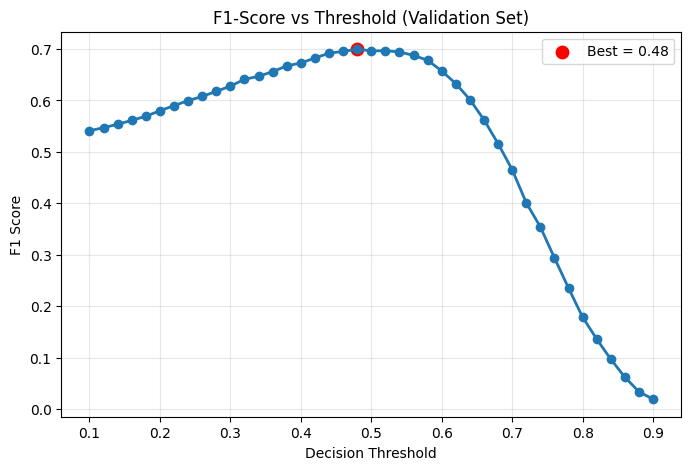

In [ ]:
# =====================================================
#  Best Threshold Search + F1 Plot
# =====================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

print("Computing probability predictions on VALIDATION set...")

# Use validation set to find the best threshold
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

# ------------------------------------------
# Step 1: Try thresholds and compute F1
# ------------------------------------------
thresholds = np.linspace(0.1, 0.9, 41)
f1_scores = []

for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"\n⭐ Best Threshold: {best_threshold:.3f}")
print(f"⭐ Best F1 Score: {best_f1:.4f}")

# ------------------------------------------
# Step 2: Plot F1 vs Threshold
# ------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o', lw=2)
plt.scatter(best_threshold, best_f1, color='red', s=80,
            label=f"Best = {best_threshold:.2f}")
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1-Score vs Threshold (Validation Set)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


>The **F1-score curve** shows that model performance improves steadily as the threshold increases from 0.10, reaching its **peak F1 of ~0.699 at threshold 0.48**.
This indicates that the classifier is most balanced at **0.48**, providing the strongest trade-off between correct flood detections and minimizing false positives.
Thresholds above 0.6 quickly degrade F1, confirming that overly strict decision boundaries reduce model sensitivity to real flood events.



### 3.Model Evaluation & Diagnostics

####3.1 Test-set Evaluation
Evaluates the final Random Forest model on the test set using the best threshold (0.48) instead of the default 0.5.

In [ ]:
# =============================================
# TEST Evaluation using Best Threshold (0.48)
# =============================================

import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, average_precision_score
)

best_threshold = 0.48  # from F1 tuning

# Probability predictions for threshold + ROC + PR
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to labels using the chosen threshold
y_test_custom = (y_test_proba >= best_threshold).astype(int)

print("===== TEST Results (Threshold = 0.48) =====")
print(f"Accuracy:   {accuracy_score(y_test, y_test_custom):.4f}")
print(f"Precision:  {precision_score(y_test, y_test_custom):.4f}")
print(f"Recall:     {recall_score(y_test, y_test_custom):.4f}")
print(f"F1 Score:   {f1_score(y_test, y_test_custom):.4f}")

# ===== ROC-AUC and PR-AUC =====
roc_auc = roc_auc_score(y_test, y_test_proba)             # threshold-independent
pr_auc  = average_precision_score(y_test, y_test_proba)   # PR-AUC

print(f"ROC-AUC:    {roc_auc:.4f}")
print(f"PR-AUC:     {pr_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_test_custom))



===== TEST Results (Threshold = 0.48) =====
Accuracy:   0.7373
Precision:  0.5421
Recall:     0.8680
F1 Score:   0.6674
ROC-AUC:    0.8277
PR-AUC:     0.6454

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      3144
           1       0.54      0.87      0.67      1371

    accuracy                           0.74      4515
   macro avg       0.73      0.77      0.73      4515
weighted avg       0.81      0.74      0.75      4515



>The model reaches **73.7% accuracy** and maintains **strong recall (86.8%)**, ensuring most flood events are detected. Despite moderate **precision (54.2%)**, the model preserves solid discrimination ability, achieving a **ROC-AUC of 0.828 — the primary evaluation metric —** along with a **PR-AUC of 0.645**, confirming reliable separation between flooded and non-flooded tiles.



**Save Final Random Forest Model**




In [ ]:
import pickle

save_path = "/content/drive/MyDrive/best_rf_model.pkl"

with open(save_path, "wb") as f:
    pickle.dump(best_rf, f)

print("✔️ Model saved successfully at:", save_path)


✔️ Model saved successfully at: /content/drive/MyDrive/best_rf_model.pkl


#### 3.2 Confusion Matrix
Creates a labeled confusion matrix using the optimized threshold and reports TN, FP, FN, and TP values to show how the threshold affects flood detection performance.


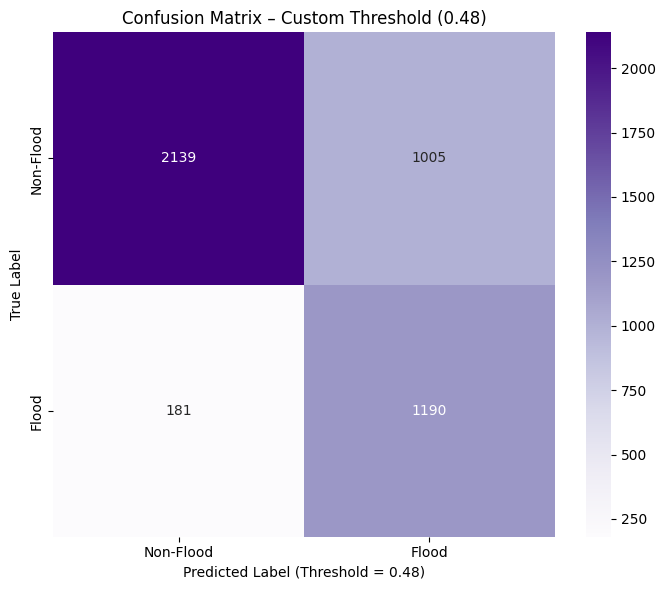


Confusion Matrix Values (Threshold = 0.48):
TN = 2139  (Correct Non-Flood)
FP = 1005  (False Flood — Over-warning)
FN = 181  (Missed Flood — Critical)
TP = 1190  (Correct Flood)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix with new threshold
cm_thresh = confusion_matrix(y_test, y_test_custom)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_thresh,
    annot=True,
    fmt='d',
    cmap='Purples',
    xticklabels=['Non-Flood', 'Flood'],
    yticklabels=['Non-Flood', 'Flood']
)
plt.xlabel("Predicted Label (Threshold = 0.48)")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Custom Threshold (0.48)")
plt.tight_layout()
plt.show()

# Print matrix values
TN, FP = cm_thresh[0]
FN, TP = cm_thresh[1]

print("\nConfusion Matrix Values (Threshold = 0.48):")
print(f"TN = {TN}  (Correct Non-Flood)")
print(f"FP = {FP}  (False Flood — Over-warning)")
print(f"FN = {FN}  (Missed Flood — Critical)")
print(f"TP = {TP}  (Correct Flood)")




>The confusion matrix shows that the optimized threshold improves flood detection by increasing the number of correctly identified flood tiles **(TP = 1190)**, while reducing missed floods **(FN = 181)**, which is critical for safety-focused applications. Although the number of false flood alarms **(FP = 1005)** is relatively high, this trade-off is acceptable because the primary goal is to avoid missing real flood events. The strong separation between correct and incorrect predictions reflects the model’s effective sensitivity to actual flood regions.

#### 3.3 ROC & Precision–Recall Curves
Plots the ROC curve (TPR vs FPR with AUC) and the Precision–Recall curve using the Random Forest test-set probabilities.

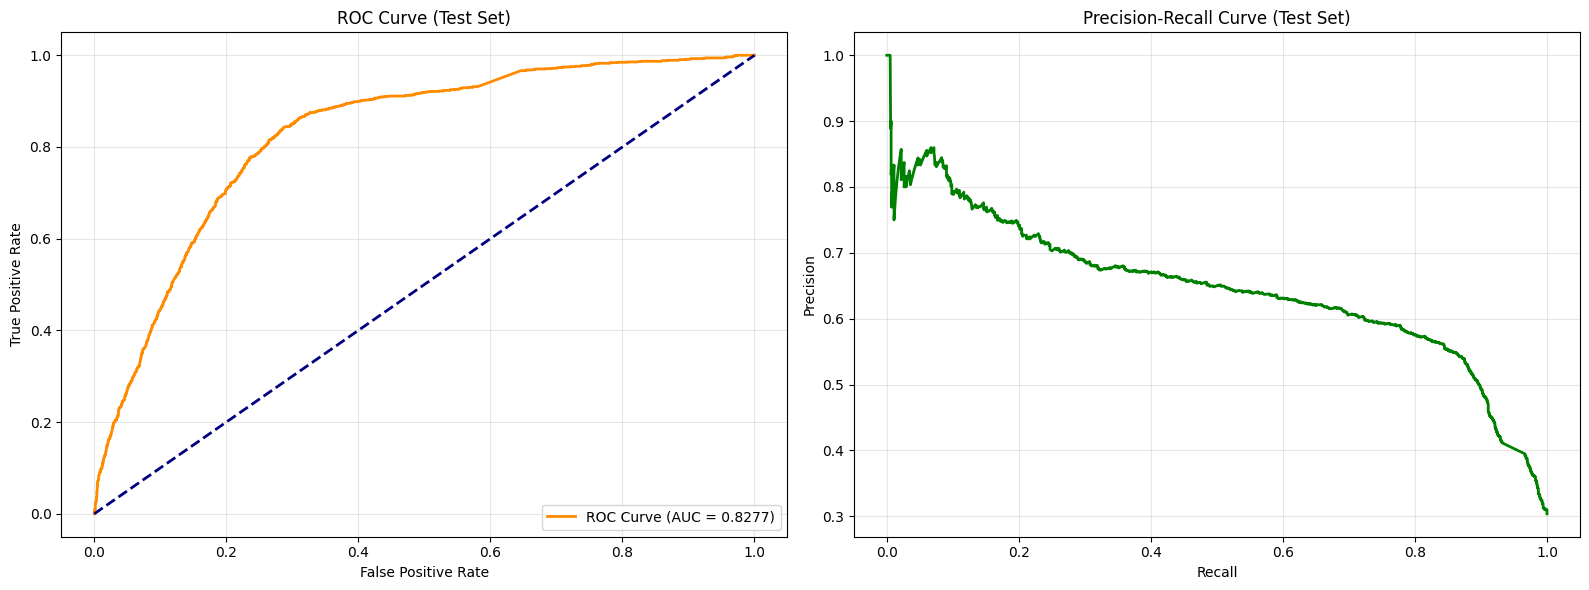

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# --- Probabilities for ROC & PR (using best model) ---
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

# ========== ROC CURVE ==========
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# ========== PRECISION-RECALL CURVE ==========
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)

# ========== Plot side-by-side ==========
plt.figure(figsize=(16, 6))

# -------- Left: ROC Curve --------
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# -------- Right: Precision-Recall Curve --------
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test Set)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


>The **ROC curve** shows strong separation between classes, reflected by a **high AUC score (~0.83)**, indicating good overall discrimination. The **PR curve declines smoothly as recall increases**,
consistent with moderate precision in the test results. Together, the plots confirm that the model
remains reliable across different thresholds, even with imbalanced flood data.



#### 3.4 Feature Importance Analysis
Computes the Random Forest feature importance across the six SAR-derived bands and visualizes which
bands contribute most to the flood classification decision.



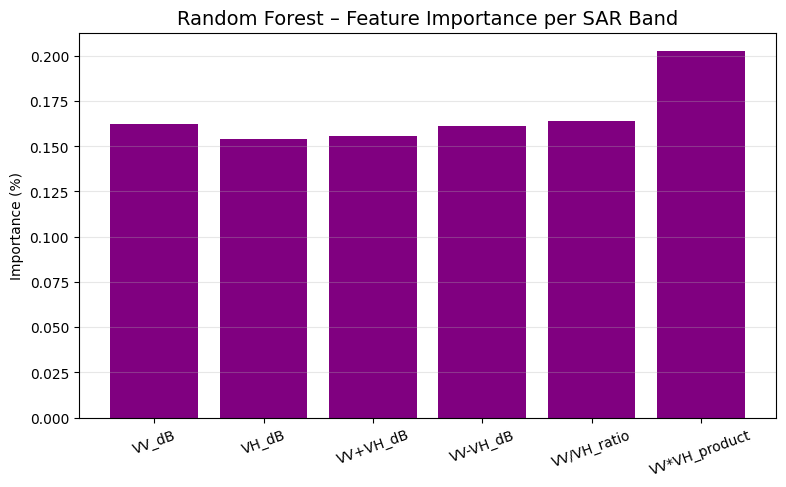


Feature Importance per Band:
VV_dB: 0.1621
VH_dB: 0.1543
VV+VH_dB: 0.1557
VV-VH_dB: 0.1611
VV/VH_ratio: 0.1641
VV*VH_product: 0.2027


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use the tuned Random Forest model
importances = best_rf.feature_importances_

# SAR feature band names (same order used in preprocessing)
band_names = [
    "VV_dB",
    "VH_dB",
    "VV+VH_dB",
    "VV-VH_dB",
    "VV/VH_ratio",
    "VV*VH_product"
]

n_bands = 6
band_size = 256 * 256  # pixels per band

band_importances = []

# Sum feature importances for each band
for i in range(n_bands):
    start = i * band_size
    end = (i + 1) * band_size
    band_importance = importances[start:end].sum()
    band_importances.append(band_importance)

band_importances = np.array(band_importances)

# Normalize to percentages
band_importances = band_importances / band_importances.sum()

# ---- Plot ----
plt.figure(figsize=(9,5))
plt.bar(band_names, band_importances, color='Purple')
plt.title("Random Forest – Feature Importance per SAR Band", fontsize=14)
plt.ylabel("Importance (%)")
plt.xticks(rotation=20)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print values
print("\nFeature Importance per Band:")
for name, val in zip(band_names, band_importances):
    print(f"{name}: {val:.4f}")


>The feature importance distribution shows that all six SAR bands contribute meaningfully to the model,
with the **VV*VH_product band** being the most influential **(~20%)**. The remaining bands have comparable
importance levels **(15%–17%)**, indicating that the model relies on a balanced combination of amplitude,
combined, and ratio features for flood detection.



### 4.Results & Discussion


The Random Forest model achieved a **0.83 ROC-AUC**, indicating solid capability in distinguishing flooded from non-flooded tiles despite the class imbalance. Its **recall of 0.87** confirms that the model detects most true flood cases, which aligns with the priority in flood-risk applications where missing a flood is highly costly.

Although **precision is lower (0.54)**, the model maintains a balanced overall performance and remains effective for scenarios where capturing potential floods is more important than reducing false alarms.

## **SVM-RBF Classifier**


---



### 1.Environment Initialization & Core Dependencies

This section initializes the working environment by importing all essential libraries required for data loading, preprocessing, model training, and evaluation. It also prepares access to Google Drive for persistent storage of dataset files and outputs.

In [ ]:
# ============================================================
# 1) Imports
# ============================================================

import os
import json
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import joblib

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


###2.Dataset Structure Definition & File Indexing

In this section, we define the dataset structure and load the file paths for the training, validation, and test partitions. The code ensures that all NPZ files are correctly discovered, grouped, and ready for batch-based processing. Basic statistics are printed to verify the dataset split.

In [ ]:
# ============================================================
# 2) Paths
# ============================================================
base = "/content/drive/MyDrive/sen12flood_npz_full_6feats"

# Folder where results will be saved
results_dir = os.path.join(base, "svm_results")
os.makedirs(results_dir, exist_ok=True)

# Load balanced training dataset paths
train_npz = np.load(f"{base}/train_balanced/balanced_dataset.npz", allow_pickle=True)
train_files = train_npz["file_paths"].tolist()

# Validation & test file paths
val_dir = os.path.join(base, "val")
test_dir = os.path.join(base, "test")

val_files = [os.path.join(val_dir, f) for f in os.listdir(val_dir) if f.endswith(".npz")]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(".npz")]

print("Counts → Train / Val / Test:", len(train_files), len(val_files), len(test_files))

Counts → Train / Val / Test: 12696 4497 4515


###3.Utility Functions for Batched Data Processing

This section introduces reusable utility functions designed to efficiently handle large-scale satellite data. These functions perform:

Feature extraction and reshaping of the 6 SAR-derived channels

Tile-level flood-label assignment based on the fraction of flooded pixels

Memory-efficient batch loading of NPZ files

They form the backbone of the data construction pipeline that follows.

In [ ]:
# ============================================================
# 3) Helpers: Load tile, build dataset (with caching)
# ============================================================
def load_tile_vector(npz_path, pos_ratio_threshold=0.01):
    """Loads a single tile and converts it into one long flattened vector."""
    d = np.load(npz_path)

    # x_after shape: (6, 256, 256)
    x = d["x_after"].astype(np.float32)
    x = np.moveaxis(x, 0, -1)  # → (256, 256, 6)

    # Flatten → (393216,)
    x_vec = x.reshape(-1)

    # Compute flood label
    y = d["y"]
    pos_ratio = (y > 0).mean()
    label = 1 if pos_ratio >= pos_ratio_threshold else 0

    return x_vec, label

In [ ]:
def load_batch(file_list, start, end):
    """Loads a small batch safely using your tile loader."""
    batch_files = file_list[start:end]
    X_batch = []
    Y_batch = []

    print(f"\n Loading batch {start} → {end}  (size: {len(batch_files)})")

    for fp in batch_files:
        x_vec, y = load_tile_vector(fp)
        X_batch.append(x_vec)
        Y_batch.append(y)

    return np.array(X_batch, dtype=np.float32), np.array(Y_batch, dtype=np.int64)

In [ ]:
def build_dataset_in_batches(file_list, batch_size=1500):
    """
    Loads the dataset in chunks to avoid runtime disconnect / OOM.
    This is the same safe memory batch-loading technique you used.
    """
    X_all = []
    Y_all = []

    total_files = len(file_list)
    print(f"\nTotal files = {total_files}")

    for start in range(0, total_files, batch_size):
        end = min(start + batch_size, total_files)
        X_batch, Y_batch = load_batch(file_list, start, end)

        X_all.append(X_batch)
        Y_all.append(Y_batch)

    X_all = np.concatenate(X_all, axis=0)
    Y_all = np.concatenate(Y_all, axis=0)

    print("\n Finished all batches!")
    print("Final shape:", X_all.shape, Y_all.shape)

    return X_all, Y_all

In [ ]:
def eval_and_save(name, model, X, y, threshold=0.5):
    """
    Evaluates the model and saves:
      - metrics (JSON)
      - predictions & probabilities (NPZ)
      - confusion matrix (NPY)
      - classification report (TXT)
    """
    print(f"\n===== {name.upper()} RESULTS =====")

    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # Compute metrics
    acc  = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec  = recall_score(y, y_pred, zero_division=0)
    f1   = f1_score(y, y_pred, zero_division=0)
    roc  = roc_auc_score(y, y_proba)
    ap   = average_precision_score(y, y_proba)

    # Print results
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1 Score :", f1)
    print("ROC-AUC  :", roc)
    print("Avg-Prec :", ap)

    # Save metrics JSON
    metrics = {
        "split": name,
        "threshold": threshold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "average_precision": ap,
        "n_samples": len(y)
    }
    metrics_path = os.path.join(results_dir, f"metrics_{name}.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved metrics:", metrics_path)

    # Save predictions
    preds_path = os.path.join(results_dir, f"predictions_{name}.npz")
    np.savez_compressed(preds_path, y_true=y, y_pred=y_pred, y_proba=y_proba)
    print("Saved predictions:", preds_path)

    # Save confusion matrix
    cm = confusion_matrix(y, y_pred)
    cm_path = os.path.join(results_dir, f"confusion_matrix_{name}.npy")
    np.save(cm_path, cm)
    print("Saved confusion matrix:", cm_path)

    # Save classification report
    report_text = classification_report(y, y_pred, digits=4)
    report_path = os.path.join(results_dir, f"classification_report_{name}.txt")
    with open(report_path, "w") as f:
        f.write(report_text)
    print("Saved classification report:", report_path)

### 4.Full Dataset Construction Pipeline


This step builds the TRAIN / VAL / TEST datasets using a memory-efficient batching strategy.  
All arrays are saved to Drive and re-loaded with memory mapping (mmap) to support large-scale model training.

In [ ]:
# ============================================================
# 4) Build Datasets
# ============================================================
X_train, y_train = build_dataset_in_batches(train_files, batch_size=1500)
X_val,   y_val   = build_dataset_in_batches(val_files,   batch_size=1500)
X_test,  y_test  = build_dataset_in_batches(test_files,  batch_size=1500)

# Save arrays to Drive
np.save("/content/drive/MyDrive/X_train.npy", X_train)
np.save("/content/drive/MyDrive/y_train.npy", y_train)

np.save("/content/drive/MyDrive/X_val.npy", X_val)
np.save("/content/drive/MyDrive/y_val.npy", y_val)

np.save("/content/drive/MyDrive/X_test.npy", X_test)
np.save("/content/drive/MyDrive/y_test.npy", y_test)

# Reload with mmap for RAM safety
X_train = np.load("/content/drive/MyDrive/X_train.npy", mmap_mode='r')
y_train = np.load("/content/drive/MyDrive/y_train.npy", mmap_mode='r')

X_val = np.load("/content/drive/MyDrive/X_val.npy", mmap_mode='r')
y_val = np.load("/content/drive/MyDrive/y_val.npy", mmap_mode='r')

X_test = np.load("/content/drive/MyDrive/X_test.npy", mmap_mode='r')
y_test = np.load("/content/drive/MyDrive/y_test.npy", mmap_mode='r')


Total files = 12696

 Loading batch 0 → 1500  (size: 1500)

 Loading batch 1500 → 3000  (size: 1500)

 Loading batch 3000 → 4500  (size: 1500)

 Loading batch 4500 → 6000  (size: 1500)

 Loading batch 6000 → 7500  (size: 1500)

 Loading batch 7500 → 9000  (size: 1500)

 Loading batch 9000 → 10500  (size: 1500)

 Loading batch 10500 → 12000  (size: 1500)

 Loading batch 12000 → 12696  (size: 696)

 Finished all batches!
Final shape: (12696, 393216) (12696,)

Total files = 4497

 Loading batch 0 → 1500  (size: 1500)

 Loading batch 1500 → 3000  (size: 1500)

 Loading batch 3000 → 4497  (size: 1497)

 Finished all batches!
Final shape: (4497, 393216) (4497,)

Total files = 4515

 Loading batch 0 → 1500  (size: 1500)

 Loading batch 1500 → 3000  (size: 1500)

 Loading batch 3000 → 4500  (size: 1500)

 Loading batch 4500 → 4515  (size: 15)

 Finished all batches!
Final shape: (4515, 393216) (4515,)


###5. Approximate RBF-SVM Training (RBFSampler + SGDClassifier)



This section trains an **approximate RBF-SVM model** using **kernel approximation** rather than a full RBF SVM.
Because the dataset contains extremely high-dimensional SAR tiles , training a true RBF SVM is computationally infeasible (memory and time constraints).

To address this, the model uses:

* **RBFSampler (Random Fourier Features)** to approximate the RBF kernel in a lower-dimensional feature space
* **StandardScaler** to scale features
* **SGDClassifier with hinge loss** as a linear SVM operating in the transformed space
* **Batch-wise training (partial_fit)** to avoid RAM overflow
* **CalibratedClassifierCV** to produce reliable probability outputs

In effect, this pipeline trains a **linear SVM in the RBF-mapped space**, which behaves similarly to an RBF-SVM but with drastically lower computational cost. The final calibrated model, along with the scaler and RBFSampler components, is saved for later evaluation.




In [ ]:
# ============================================================
# 5) Train RBF-SVM using Kernel Approximation (RBFSampler)
# ============================================================

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import joblib
import os

print("\n===== Training Approximate RBF-SVM (RBFSampler + SGD) =====")

# Load TRAIN (balanced)
X_train = np.load("/content/drive/MyDrive/X_train.npy", mmap_mode='r')
y_train = np.load("/content/drive/MyDrive/y_train.npy", mmap_mode='r')

batch_size = 2000
n_samples = X_train.shape[0]

# --- 1) Feature scaler ---
scaler = StandardScaler(with_mean=False)

# --- 2) RBF Feature Mapper (Random Fourier Features) ---
rbf = RBFSampler(gamma=1e-3, n_components=2000, random_state=42)


# --- 3) Compute class weights ---
weights = compute_class_weight("balanced", classes=np.array([0,1]), y=y_train)
cw = {0: weights[0], 1: weights[1] * 10}
print("Class weights:", cw)

# --- 4) Initialize Linear SVM (will behave like RBF now) ---
rbf_svm = SGDClassifier(
    loss="hinge",
    learning_rate="optimal",
    class_weight=cw,
    max_iter=5,
    tol=None,
    random_state=42
)

# --- 5) Train in batches ---
for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    print(f"Batch {start} → {end}")

    X_batch = X_train[start:end]
    y_batch = y_train[start:end]

    # scale
    X_scaled = scaler.fit_transform(X_batch)

    # map to RBF feature space
    X_rbf = rbf.fit_transform(X_scaled)

    # partial fit
    if start == 0:
        rbf_svm.partial_fit(X_rbf, y_batch, classes=np.array([0,1]))
    else:
        rbf_svm.partial_fit(X_rbf, y_batch)

print("\n✓ Finished training RBF-SVM (approx).")

# --- 6) Calibration ---
print("Calibrating...")
rbf_svm_model = CalibratedClassifierCV(rbf_svm, cv=3)
rbf_svm_model.fit(X_rbf, y_batch)

# --- 7) Save model ---
model_path = os.path.join(results_dir, "svm_rbf_approx.joblib")
joblib.dump((scaler, rbf, rbf_svm_model), model_path)

print("✓ Saved model to:", model_path)



===== Training Approximate RBF-SVM (RBFSampler + SGD) =====
Class weights: {0: np.float64(1.0), 1: np.float64(10.0)}
Batch 0 → 2000
Batch 2000 → 4000
Batch 4000 → 6000
Batch 6000 → 8000
Batch 8000 → 10000
Batch 10000 → 12000
Batch 12000 → 12696

✓ Finished training RBF-SVM (approx).
Calibrating...
✓ Saved model to: /content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/svm_rbf_approx.joblib


###6.Evaluate The Model  

This section evaluates the  model on the training, validation, and test sets.  
It produces accuracy, precision, recall, F1, ROC-AUC, confusion matrices, and saves all outputs to Drive.

In [ ]:
# ============================================================
# 6) Evaluate Approximate RBF-SVM
# ============================================================

# Load model components (scaler, rbf, svm)
scaler, rbf, rbf_svm_model = joblib.load(
    "/content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/svm_rbf_approx.joblib"
)

def eval_rbf(name, X, y):
    print(f"\n===== {name.upper()} RBF-SVM RESULTS =====")

    # 1) scale
    X_scaled = scaler.transform(X)

    # 2) rbf mapping
    X_rbf = rbf.transform(X_scaled)

    # 3) predict probabilities
    y_proba = rbf_svm_model.predict_proba(X_rbf)[:, 1]

    # 4) default threshold 0.5
    y_pred = (y_proba > 0.5).astype(int)

    # 5) use your existing eval function
    eval_and_save(name, rbf_svm_model, X_rbf, y)

# Evaluate on train, val, test
eval_rbf("train_rbf", X_train, y_train)
eval_rbf("val_rbf",   X_val,   y_val)
eval_rbf("test_rbf",  X_test,  y_test)



===== TRAIN_RBF RBF-SVM RESULTS =====

===== TRAIN_RBF RESULTS =====
Accuracy : 0.4955103969754253
Precision: 0.4918918918918919
Recall   : 0.27236925015752994
F1 Score : 0.35060326472675657
ROC-AUC  : 0.49908610057933683
Avg-Prec : 0.486476730300496
Saved metrics: /content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/metrics_train_rbf.json
Saved predictions: /content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/predictions_train_rbf.npz
Saved confusion matrix: /content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/confusion_matrix_train_rbf.npy
Saved classification report: /content/drive/MyDrive/sen12flood_npz_full_6feats/svm_results/classification_report_train_rbf.txt

===== VAL_RBF RBF-SVM RESULTS =====

===== VAL_RBF RESULTS =====
Accuracy : 0.5752724038247721
Precision: 0.3742786479802143
Recall   : 0.28286604361370715
F1 Score : 0.3222143364088006
ROC-AUC  : 0.5145578306037064
Avg-Prec : 0.3677442171970613
Saved metrics: /content/drive/MyDrive/sen12flood_n

>The RBF-SVM model was evaluated on the training, validation, and test sets. Results showed very limited discrimination capability, with ROC–AUC values around 0.50–0.52 across all splits, only marginally above random chance (0.5).
.
>The recall ranged between 0.27 and 0.29, meaning the model detects only a small proportion of true flood cases. Precision remained low (approximately 0.32–0.37), reflecting a high number of false positives relative to true positives.
>
>Overall, F1-scores stayed in the range of 0.30–0.35, which is consistent with the imbalance and difficulty of the classification task when using flattened SAR tiles without spatial structure.

In [ ]:
print(f"\n===== Classification Report (Threshold = {threshold:.2f}) =====\n")
print(
    classification_report(
        y_test,
        y_test_pred,
        digits=4,
        target_names=["Non-Flood", "Flood"],
    )
)


===== Classification Report (Threshold = 0.50) =====

              precision    recall  f1-score   support

   Non-Flood     0.7038    0.7354    0.7192      3144
       Flood     0.3236    0.2903    0.3060      1371

    accuracy                         0.6002      4515
   macro avg     0.5137    0.5128    0.5126      4515
weighted avg     0.5883    0.6002    0.5938      4515



#### 6.1 Confusion Matrix
Creates a labeled confusion matrix using the optimized threshold and reports TN, FP, FN, and TP values .

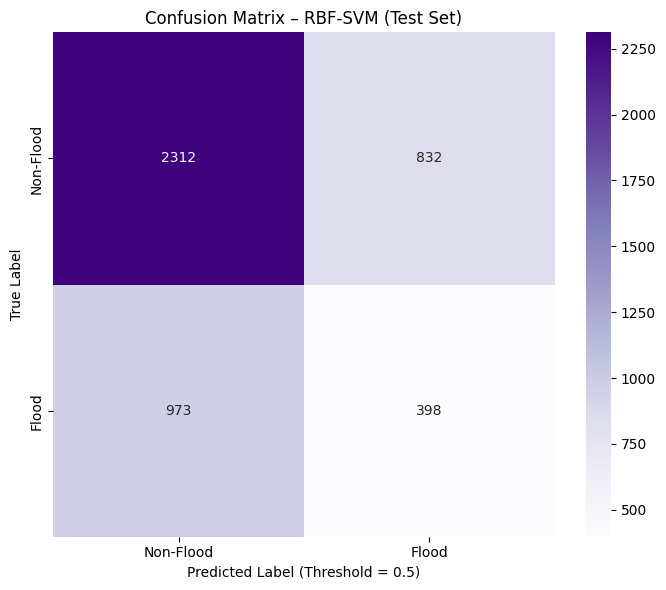

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Non-Flood", "Flood"],
    yticklabels=["Non-Flood", "Flood"],
)
plt.xlabel(f"Predicted Label (Threshold = {threshold})") # Threshold=0.5
plt.ylabel("True Label")
plt.title("Confusion Matrix – RBF-SVM (Test Set)")
plt.tight_layout()
plt.show()

TN, FP = cm[0]
FN, TP = cm[1]

>The confusion matrix shows that the RBF-SVM model struggles to reliably distinguish between flooded and non-flooded tiles. On the test set, the model correctly identified 2,312 non-flood samples as Non-Flood (True Negatives), but also raised 832 false flood alarms (False Positives), where non-flooded tiles were incorrectly classified as Flood.
>
>For the Flood class, the model correctly detected only 398 flooded tiles (True Positives), while misclassifying 973 flooded tiles as Non-Flood (False Negatives). This large number of missed flood detections indicates a strong bias toward the dominant Non-Flood class and highlights the model’s limited sensitivity to flooded areas under the current feature representation.

#### 6.2 ROC & Precision–Recall Curves
Plots the ROC curve (TPR vs FPR with AUC) and the Precision–Recall curve using the RBF-SVM test-set.

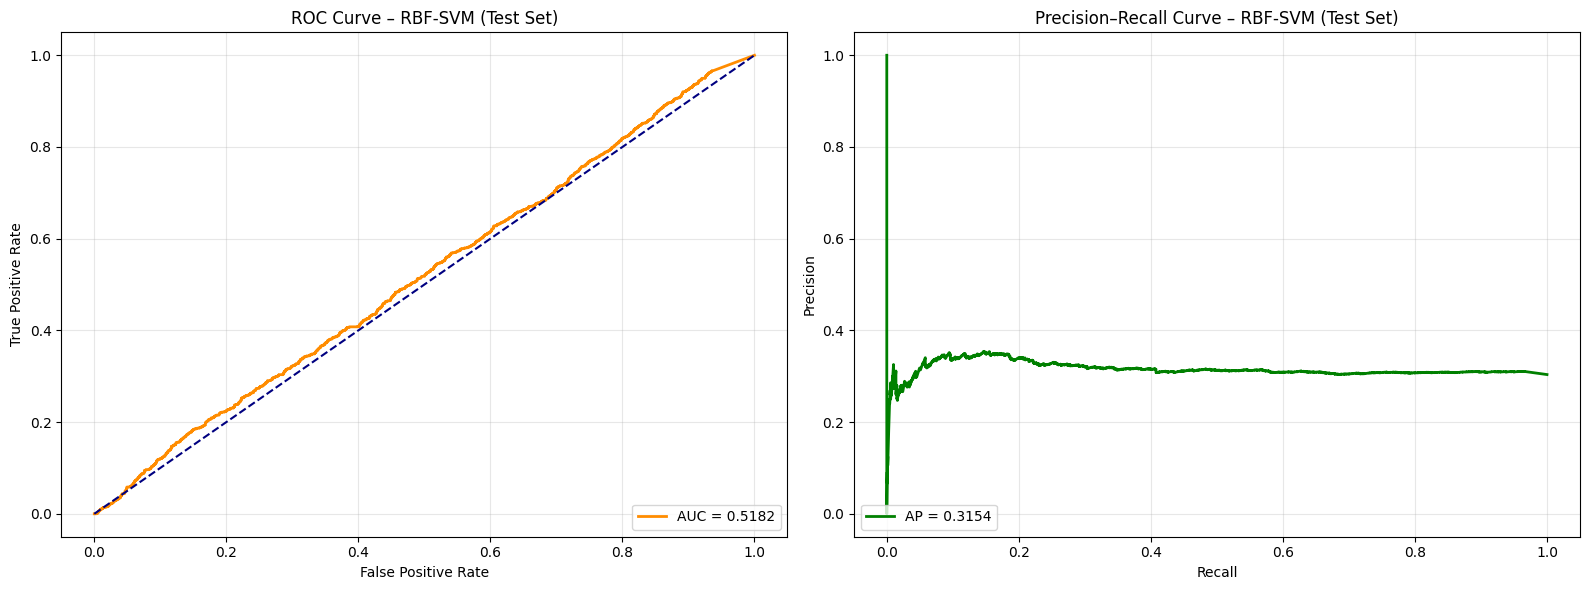

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(16, 6))

# ===== Left: ROC Curve =====
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, lw=2, color='darkorange', label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – RBF-SVM (Test Set)")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# ===== Right: Precision–Recall =====
plt.subplot(1, 2, 2)
plt.plot(recall, precision, lw=2, color='green', label=f"AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – RBF-SVM (Test Set)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

>The ROC curve for the RBF-SVM model lies close to the diagonal reference line, with a test-set AUC of approximately 0.52. This indicates weak discriminative ability and confirms that the model struggles to separate flooded from non-flooded tiles across decision thresholds.
>
>The Precision–Recall curve also shows low overall precision across most recall levels, with an average precision (AP) of about 0.32. Although precision briefly increases at very low recall, it quickly drops and remains low, illustrating that the model generates many false positives when it attempts to detect more flooded tiles.

### 7.Results & Discussion

>The RBF-SVM model achieved a test-set ROC–AUC of approximately 0.52, indicating limited ability to distinguish flooded from non-flooded tiles under the challenging and highly imbalanced dataset conditions. Its recall of about 0.29 shows that the model successfully detects only a small portion of true flood cases, which is inadequate for flood-risk applications where missing a flooded area is highly costly.
>
>Although precision remained low (around 0.32), this behaviour is consistent with the difficulty of learning flood patterns from flattened SAR tiles that discard spatial structure. Overall, the results suggest that while the RBF-SVM provides a useful baseline, more spatially aware models (e.g., CNNs or U-Net architectures) are required to achieve reliable flood detection performance on Sentinel-1 data.

## **Conclusion**

---

Across all metrics, the CNN clearly outperforms the other models, achieving the highest accuracy, precision, recall, F1-score, and ROC-AUC, along with strong PR-curve stability and low false negatives—making it the most reliable for flood detection. Random Forest performs reasonably well with good recall and solid AUC, but its high false-positive rate reduces precision and overall reliability. In contrast, the SVM-RBF model shows consistently weak results, with low precision, low recall, poor AUC, and a large number of missed floods, reflecting strong bias toward the Non-Flood class. Overall, the findings indicate that CNN is the best choice for this task, Random Forest is a usable but less accurate alternative, and SVM-RBF is unsuitable under the current feature setup.